1. Viz1: /nfs/users/ext_shikhar.srivastava/workspace/TANS/outcomes/ours/20220225_1734
2. #path = '/nfs/users/ext_shikhar.srivastava/workspace/TANS/outcomes/ours/20220225_1734/checkpoints/' 5% mse error for the saved_model_max_recall
3. path = '/nfs/users/ext_shikhar.srivastava/workspace/TANS/outcomes/ours/20220226_0040/checkpoints' 3% mse for saved_model
 


In [ ]:
#path = '/nfs/users/ext_shikhar.srivastava/workspace/TANS/outcomes/ours/20220226_0040/checkpoints'
path = '/nfs/users/ext_shikhar.srivastava/workspace/TANS/outcomes/ours/20220302_0137/checkpoints'
saved_model_path = path +'/saved_model.pt'
saved_model_max_recall_path = path + '/saved_model_max_recall.pt'

: 

In [3]:
take = saved_model_path
import torch
saved_model = torch.load(take)

In [4]:
import math
import torch
import numpy as np
#from config import *
from misc.utils import *
import torch.nn.functional as F

class PerformancePredictor(torch.nn.Module):
    def __init__(self):
        super(PerformancePredictor, self).__init__()
        self.n_dims = 128
        self.fc = torch.nn.Linear(self.n_dims*2, 1)

    def forward(self, q, m):
        p = torch.cat([q, m], 1)
        p = torch.sigmoid(self.fc(p))
        return p

class ModelEncoder(torch.nn.Module):
    def __init__(self):
        super(ModelEncoder, self).__init__()  
        self.n_dims = 128
        self.fc = torch.nn.Linear(2048, self.n_dims) #torch.nn.Linear(45+1536, self.args.n_dims) 
            
    def forward(self, v_f):
        m = v_f
        m = F.normalize(m)
        m = self.fc(m)
        m = self.l2norm(m)
        return m

    def l2norm(self, x):
        norm2 = torch.norm(x, 2, dim=1, keepdim=True)
        x = torch.div(x, norm2)
        return x
    
class QueryEncoder(torch.nn.Module):
    def __init__(self):
        super(QueryEncoder, self).__init__()
        self.n_dims = 128
        self.fc = torch.nn.Linear(512, self.n_dims) 

    def forward(self, D):
        q = []
        for d in D:
            _q = self.fc(d) 
            _q = torch.mean(_q, 0)
            _q = self.l2norm(_q.unsqueeze(0))
            q.append(_q)
        q = torch.stack(q).squeeze()
        return q

    def l2norm(self, x):
        norm2 = torch.norm(x, 2, dim=1, keepdim=True)
        x = torch.div(x, norm2)
        return x

In [5]:

device = 'cpu'
enc_q = QueryEncoder().to(device) 
enc_q.load_state_dict(saved_model['enc_q'])
enc_m = ModelEncoder().to(device)
enc_m.load_state_dict(saved_model['enc_m'])
pred = PerformancePredictor().to(device)
pred.load_state_dict(saved_model['predictor'])

epoch = saved_model['epoch']
recall = saved_model['recall']
medr = saved_model['medr']
meanr = saved_model['meanr']
mse = saved_model['mse']

In [6]:
model_zoo_path = '/nfs/projects/mbzuai/shikhar/datasets/ofa/our_mod_zoo.pt'
data_path = '/nfs/projects/mbzuai/shikhar/datasets/ofa/our_data_path'
import os
model_zoo = torch.load(model_zoo_path)
query = torch.load(os.path.join(data_path, 'meta_train.pt'))

In [7]:
query.keys()

dict_keys(['fetal_ultrasound', 'CTPancreas', 'IHD_Brain', 'Brain_MRI', 'MosMed', 'RSPECT', 'ProstateMRI', 'kits', 'Covid19XRay', 'LiTs', 'RSNAXRay', 'ImageCHD'])

In [8]:
query['fetal_ultrasound'].keys()

dict_keys(['task', 'clss', 'nclss', 'x_query_train', 'y_query_train', 'x_query_test', 'y_query_test', 'type', 'task_type'])

torch.stack(query['zalando-store-crawl_dqmonn_0_6']['x_query_train']).shape

In [9]:
import pandas as pd
f_model_zoo = pd.DataFrame(model_zoo)

In [10]:
f_model_zoo

,best_epoch,f1,loss,model_path,dataset,model,with_aug,balanced,pretrained,batch_128,topn,f_emb
0,84,0.788686,0.435503,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
1,75,0.800681,0.426641,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,92,0.788177,0.400816,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
3,46,0.452632,0.278173,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet18,False,False,False,False,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4,97,0.790698,0.439231,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
...,...,...,...,...,...,...,...,...,...,...,...,...
471,44,0.702703,0.143112,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,MosMed,resnet18,True,False,False,False,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(2...."
472,59,0.544178,1.145104,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Covid19XRay,densenet121,True,False,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
473,85,0.530511,0.094970,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,kits,resnet50,True,True,False,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
474,88,0.531792,1.122675,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Covid19XRay,resnet18,True,False,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


def process_topol(topol):
    ks = topol[:20] 
    e = topol[20:40]
    d = topol[40:]
    tmp = torch.zeros(len(ks))
    for stage, num_layer in enumerate(d):
        tmp[stage*4:stage*4+num_layer] = 1
    ks = torch.tensor(ks) * tmp
    e = torch.tensor(e) * tmp
    topol = [int(t) for t in [*ks.tolist(), *e.tolist(), *d]]
    return topol

In [11]:
set(model_zoo['dataset'])

{'Brain_MRI',
 'CTPancreas',
 'Covid19XRay',
 'IHD_Brain',
 'ImageCHD',
 'LiTs',
 'MosMed',
 'ProstateMRI',
 'RSNAXRay',
 'RSPECT',
 'kits'}

In [12]:
pd.DataFrame(model_zoo)

,best_epoch,f1,loss,model_path,dataset,model,with_aug,balanced,pretrained,batch_128,topn,f_emb
0,84,0.788686,0.435503,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
1,75,0.800681,0.426641,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,92,0.788177,0.400816,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
3,46,0.452632,0.278173,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet18,False,False,False,False,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4,97,0.790698,0.439231,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
...,...,...,...,...,...,...,...,...,...,...,...,...
471,44,0.702703,0.143112,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,MosMed,resnet18,True,False,False,False,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(2...."
472,59,0.544178,1.145104,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Covid19XRay,densenet121,True,False,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
473,85,0.530511,0.094970,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,kits,resnet50,True,True,False,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
474,88,0.531792,1.122675,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Covid19XRay,resnet18,True,False,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


Collate Dataset and Model Embeddings.
1. Iterate on all datasets
    1. First embed dataset
    2. Then pick models trained on those datasets. Embed those models.


In [13]:
DATASET_ATTR = {
    "MosMed": {
        "organ": "Lungs",
        "pathologies": "COVID-19",
        "location": ["Russia"],
        "size": 3200,
        "modality": "CT",
        "classes": ["COVID-19 Positive", "COVID-19 Negative"],
    },
    "kits": {
        "organ": "Kidney",
        "pathologies": "Cancer",
        "location": ["USA"],
        "size": 13888,
        "modality": "CT",
        "classes": ["Benign", "Malignant"],
    },
    "LiTs": {
        "organ": "Liver",
        "pathologies": "Cancer",
        "location": ["Germany", "Netherlands", "Canada", "Israel"],
        "size": 8384,
        "modality": "CT",
        "classes": ["No_Tumor", "Tumor"],
    },
    "RSPECT": {
        "organ": "Lungs",
        "pathologies": "Pulmonary Embolism",
        "location": ["Australia", "Turkey", "USA", "Canada", "Brazil"],
        "size": 15000,
        "modality": "CT",
        "classes": ["No_PE", "PE"],
    },
    "IHD_Brain": {
        "organ": "Brain",
        "pathologies": "Intracranial Hemorrhage",
        "location": ["USA", "Brazil"],
        "size": 15000,
        "modality": "CT",
        "classes": ["No_IHD", "IHD"],
    },
    "ImageCHD": {
        "organ": "Heart",
        "pathologies": "Congenital Heart Disease",
        "location": ["China"],
        "size": 6336,
        "modality": "CT",
        "classes": ["No_CHD", "CHD"],
    },
    "CTPancreas": {
        "organ": "Pancreas",
        "pathologies": "Pancreatic Cancer",
        "location": ["USA"],
        "size": 5120,
        "modality": "CT",
        "classes": ["No_Tumor", "Tumor"],
    },
    "Brain_MRI": {
        "organ": "Brain",
        "pathologies": "Brain Tumour",
        "location": ["Global"],
        "size": 3160,
        "modality": "MRI",
        "classes": [
            "glioma_tumor",
            "meningioma_tumor",
            "no_tumor",
            "pituitary_tumor",
        ],
    },
    "ProstateMRI": {
        "organ": "Prostate",
        "pathologies": "Prostate Cancer",
        "location": ["USA"],
        "size": 2561,
        "modality": "MRI",
        "classes": ["No_Tumor", "Tumor"],
    },
    "RSNAXRay": {
        "organ": "Lungs",
        "pathologies": "Tuberculosis",
        "location": ["USA", "China"],
        "size": 801,
        "modality": "Xray",
        "classes": ["No_TB", "TB"],
    },
    "Covid19XRay": {
        "organ": "Lungs",
        "pathologies": "COVID-19",
        "location": ["Spain", "USA"], # Check again
        "size": 6057,
        "modality": "Xray",
        "classes": [
            "Negative for Pneumonia",
            "Typical Appearance",
            "Indeterminate Appearance",
            "Atypical Appearance",
        ],
    },
}


In [14]:
f_model_zoo

,best_epoch,f1,loss,model_path,dataset,model,with_aug,balanced,pretrained,batch_128,topn,f_emb
0,84,0.788686,0.435503,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
1,75,0.800681,0.426641,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,92,0.788177,0.400816,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
3,46,0.452632,0.278173,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet18,False,False,False,False,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4,97,0.790698,0.439231,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
...,...,...,...,...,...,...,...,...,...,...,...,...
471,44,0.702703,0.143112,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,MosMed,resnet18,True,False,False,False,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(2...."
472,59,0.544178,1.145104,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Covid19XRay,densenet121,True,False,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
473,85,0.530511,0.094970,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,kits,resnet50,True,True,False,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
474,88,0.531792,1.122675,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Covid19XRay,resnet18,True,False,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


In [15]:
# Get Trained embeddings
import torch
data_emb_list = list()
n_datasets = 100
i = 1
for dataset in list(set(model_zoo['dataset'])):            
    enc = enc_q([torch.stack(query[dataset]['x_query_train'])])
    d_emb = {'name': f'{dataset}', 'emb': enc.detach().cpu().numpy(), 'dataset': dataset,  'color':i, 'type': 'data'}
    for key, value in DATASET_ATTR[dataset].items():
        d_emb[key] = value

    data_emb_list.append(d_emb)

    dataset_models = f_model_zoo[f_model_zoo['dataset'] == dataset]
    
    # iterate over dataframe

    for index, row in dataset_models.iterrows():
        #model_name = row['model_name']
        #topol = torch.tensor(process_topol(row['topol']))
        enc = enc_m(torch.tensor(row['f_emb']).unsqueeze(0))
        m_emb = {'name': 'M_%.2f'%(row["f1"]), \
            'emb': enc.squeeze().detach().cpu().numpy(), \
            'color':i, 'type': 'model'
            }
        
        row_dict = row.to_dict()
        for key, value in row_dict.items():
           m_emb[key] = value 
            
        data_emb_list.append(m_emb)
        
    i += 1

/tmp/ipykernel_23223/574986753.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  enc = enc_m(torch.tensor(row['f_emb']).unsqueeze(0))


In [16]:
pd.DataFrame(data_emb_list)

,name,emb,dataset,color,type,organ,pathologies,location,size,modality,...,f1,loss,model_path,model,with_aug,balanced,pretrained,batch_128,topn,f_emb
0,kits,"[-0.005594138, -0.0095899, 0.07248677, -0.0492...",kits,1,data,Kidney,Cancer,[USA],13888.0,CT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M_0.81,"[0.04138334, -0.012536877, 0.06845247, -0.0717...",kits,1,model,NaN,NaN,NaN,NaN,NaN,...,0.806400,0.377712,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,mobilenet_v2,True,True,False,True,top-4,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,M_0.56,"[-0.0047132517, 0.121488966, 0.03604799, -0.10...",kits,1,model,NaN,NaN,NaN,NaN,NaN,...,0.557377,0.348348,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,densenet121,True,False,True,True,top-4,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
3,M_0.46,"[0.03324844, 0.09004993, 0.0066323155, -0.0760...",kits,1,model,NaN,NaN,NaN,NaN,NaN,...,0.463333,0.644624,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,efficientnet_b4,True,False,True,True,top-4,"[tensor(-0.0041), tensor(-0.0534), tensor(-0.0..."
4,M_0.56,"[0.026239507, 0.09473723, 0.07066414, -0.10601...",kits,1,model,NaN,NaN,NaN,NaN,NaN,...,0.555184,0.425856,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,efficientnet_b4,True,False,False,True,top-4,"[tensor(-0.0368), tensor(-0.0006), tensor(-0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,M_0.18,"[0.05674139, 0.12912692, -0.10281922, -0.05077...",RSPECT,11,model,NaN,NaN,NaN,NaN,NaN,...,0.181818,0.041731,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,resnet50,False,False,False,False,top-7,"[tensor(0.), tensor(0.), tensor(0.0073), tenso..."
483,M_0.82,"[0.113287136, 0.12428184, -0.08455339, -0.0170...",RSPECT,11,model,NaN,NaN,NaN,NaN,NaN,...,0.815152,0.404225,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,mobilenet_v2,True,True,False,True,top-7,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
484,M_0.73,"[0.042679224, 0.1299874, -0.12249031, -0.03643...",RSPECT,11,model,NaN,NaN,NaN,NaN,NaN,...,0.726582,0.718482,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,resnet50,True,True,True,True,top-7,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
485,M_0.83,"[0.10129377, 0.13581342, -0.11122052, -0.07878...",RSPECT,11,model,NaN,NaN,NaN,NaN,NaN,...,0.833083,0.466587,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,efficientnet_b4,True,True,True,True,top-7,"[tensor(-0.0299), tensor(-0.0855), tensor(-0.0..."


### Performance Predictor's prediction of (model, dataset) performance

In [17]:

dataset_list = list(set(model_zoo['dataset']))
predicted_data_model = list()
for dataset in dataset_list:
    for index, row in pd.DataFrame(model_zoo).iterrows():

        # All (Dataset ,Model) pairs. Using model_path as unique identifier of model
        q_encoding = [torch.stack(query[dataset]['x_query_train'])]
        m_encoding = torch.tensor(row['f_emb']).unsqueeze(0)
        q_emb = enc_q(q_encoding).detach().unsqueeze(0).cpu().numpy()
        m_emb = enc_m(m_encoding).detach().cpu().numpy()
        #print(q_emb.shape, m_emb.shape)
        pred_emb = pred(torch.from_numpy(q_emb).to(device), torch.from_numpy(m_emb).to(device))
        pred_emb = pred_emb.detach().cpu().numpy()
        pred_emb = pred_emb.squeeze()
        
        store = {'target_dataset': dataset, 'pred_f1': pred_emb}
        for key, value in row.to_dict().items():
            store[key] = value
        predicted_data_model.append(store)

d_m = pd.DataFrame(predicted_data_model)
# Show all rows
temp = d_m [d_m['target_dataset'] == d_m['dataset']][['target_dataset', 'pred_f1', 'model', 'f1', 'dataset']]
# calculate MSE between temp['f1'], temp['pred_f1'] 
f1 = temp['f1'].to_numpy()
pred_f1 = temp['pred_f1'].to_numpy()
import math, numpy
# calculate Mean Squared Error between f1 and pred_f1
mse = np.mean((f1 - pred_f1)**2)

abs_dif = np.abs(pred_f1 - f1)
# calculate mean, standard deviation of abs_dif
mean = np.mean(abs_dif)
std = np.std(abs_dif)


/tmp/ipykernel_23223/1786645434.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  m_encoding = torch.tensor(row['f_emb']).unsqueeze(0)


In [18]:
print(mean, std)

0.04693440371669786 0.052222290856634206


In [19]:
d_m

,target_dataset,pred_f1,best_epoch,f1,loss,model_path,dataset,model,with_aug,balanced,pretrained,batch_128,topn,f_emb
0,kits,0.5323114,84,0.788686,0.435503,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
1,kits,0.56033754,75,0.800681,0.426641,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,kits,0.5733329,92,0.788177,0.400816,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
3,kits,0.19902958,46,0.452632,0.278173,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet18,False,False,False,False,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4,kits,0.54890424,97,0.790698,0.439231,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5231,RSPECT,0.7674374,44,0.702703,0.143112,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,MosMed,resnet18,True,False,False,False,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(2...."
5232,RSPECT,0.77989274,59,0.544178,1.145104,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Covid19XRay,densenet121,True,False,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
5233,RSPECT,0.76567966,85,0.530511,0.094970,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,kits,resnet50,True,True,False,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
5234,RSPECT,0.7867616,88,0.531792,1.122675,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Covid19XRay,resnet18,True,False,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


### Transfer Learning performance on Validation Samples!

In [20]:
file = 'transfer.csv'
import pandas as pd
transfer = pd.read_csv(file)[['source_model_path','source_dataset','target_dataset','f1']]
predicted_data_model = list()
for index, row in transfer.iterrows():
    
    q_encoding = [torch.stack(query[row['target_dataset']]['x_query_train'])]
    model_info = f_model_zoo[f_model_zoo['model_path'] == row['source_model_path']].reset_index(drop=True)
    m_encoding = torch.tensor(model_info['f_emb'][0]).unsqueeze(0)
    q_emb = enc_q(q_encoding).detach().unsqueeze(0).cpu().numpy()
    m_emb = enc_m(m_encoding).detach().cpu().numpy()
    #print(q_emb.shape, m_emb.shape)
    pred_emb = pred(torch.from_numpy(q_emb).to(device), torch.from_numpy(m_emb).to(device))
    pred_emb = pred_emb.detach().cpu().numpy()
    pred_emb = pred_emb.squeeze()
    predicted_data_model.append({'model': row['source_model_path'], 'target_dataset': row['target_dataset'], 'pred_f1': pred_emb, 'f1': row['f1']})

/tmp/ipykernel_23223/2288285518.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  m_encoding = torch.tensor(model_info['f_emb'][0]).unsqueeze(0)


In [21]:
p_m = pd.DataFrame(predicted_data_model)

In [22]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(p_m, test_size=0.2, random_state=50)
train_transfer = train.reset_index(drop=True)
test_transfer = test.reset_index(drop=True)

In [23]:
# calculate mean and standard deviation of MSE between train_transfer['f1'], train_transfer['pred_f1']
train_f1 = test_transfer['f1'].to_numpy()
train_pred_f1 = test_transfer['pred_f1'].to_numpy()
import math, numpy
# calculate Mean Squared Error between f1 and pred_f1
test_mse = np.mean((train_f1 - train_pred_f1)**2)

In [24]:
# calculate mean and standard deviation of MSE between train_transfer['f1'], train_transfer['pred_f1']
train_f1 = train_transfer['f1'].to_numpy()
train_pred_f1 = train_transfer['pred_f1'].to_numpy()
import math, numpy
# calculate Mean Squared Error between f1 and pred_f1
train_mse = np.mean((train_f1 - train_pred_f1)**2)

In [25]:
train_mse

0.0078064097340552795

In [26]:
test_mse

0.004016513337067027

In [27]:
file = 'transfer.csv'
import pandas as pd
transfer = pd.read_csv(file)[['source_model_path','source_dataset','target_dataset','f1']]
# Split a pandas dataframe into train and test split
from sklearn.model_selection import train_test_split
train, test = train_test_split(transfer, test_size=0.2, random_state=50)
train_transfer = train.reset_index(drop=True)
test_transfer = test.reset_index(drop=True)
# Write the files using torch
import torch
torch.save(train_transfer, 'train_transfer_1.pt')
torch.save(test_transfer, 'test_transfer_1.pt')

In [28]:
transfer

,source_model_path,source_dataset,target_dataset,f1
0,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,ProstateMRI,kits,0.484182
1,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Brain_MRI,IHD_Brain,0.707317
2,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,Brain_MRI,0.872581
3,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Brain_MRI,RSPECT,0.775966
4,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,kits,RSPECT,0.803954
...,...,...,...,...
572,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,ProstateMRI,IHD_Brain,0.759941
573,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,ProstateMRI,IHD_Brain,0.759878
574,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,ProstateMRI,IHD_Brain,0.759146
575,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,ProstateMRI,IHD_Brain,0.769010


In [29]:
len(train['target_dataset'].unique())

11

In [30]:
test

,source_model_path,source_dataset,target_dataset,f1
243,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,RSNAXRay,CTPancreas,0.819242
190,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Brain_MRI,IHD_Brain,0.772093
382,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Brain_MRI,IHD_Brain,0.777879
145,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Brain_MRI,IHD_Brain,0.746447
555,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,ProstateMRI,IHD_Brain,0.803226
...,...,...,...,...
523,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,Covid19XRay,0.545004
88,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,LiTs,MosMed,0.779582
222,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,MosMed,Brain_MRI,0.835484
11,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,Brain_MRI,0.924194


In [31]:
train

,source_model_path,source_dataset,target_dataset,f1
127,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,kits,Covid19XRay,0.496284
179,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,kits,ProstateMRI,0.043478
206,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,kits,0.553299
431,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,kits,CTPancreas,0.762178
539,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,RSPECT,0.682150
...,...,...,...,...
70,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,LiTs,Covid19XRay,0.554913
132,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,kits,RSNAXRay,0.688797
289,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Brain_MRI,ImageCHD,0.166667
109,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,ProstateMRI,0.583851


train_transfer['source_model_path']

model_zoo = torch.load('/nfs/projects/mbzuai/shikhar/datasets/ofa/our_mod_zoo.pt')

train_transfer = torch.load('train_transfer.pt')

d_m = pd.DataFrame(predicted_data_model)


In [32]:
d_m

,target_dataset,pred_f1,best_epoch,f1,loss,model_path,dataset,model,with_aug,balanced,pretrained,batch_128,topn,f_emb
0,kits,0.5323114,84,0.788686,0.435503,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
1,kits,0.56033754,75,0.800681,0.426641,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,kits,0.5733329,92,0.788177,0.400816,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
3,kits,0.19902958,46,0.452632,0.278173,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet18,False,False,False,False,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4,kits,0.54890424,97,0.790698,0.439231,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5231,RSPECT,0.7674374,44,0.702703,0.143112,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,MosMed,resnet18,True,False,False,False,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(2...."
5232,RSPECT,0.77989274,59,0.544178,1.145104,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Covid19XRay,densenet121,True,False,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
5233,RSPECT,0.76567966,85,0.530511,0.094970,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,kits,resnet50,True,True,False,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
5234,RSPECT,0.7867616,88,0.531792,1.122675,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Covid19XRay,resnet18,True,False,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


In [33]:

f1 = d_m['f1'].to_numpy()
pred_f1 = d_m['pred_f1'].to_numpy()
import math, numpy
# calculate Mean Squared Error between f1 and pred_f1
mse = np.mean((f1 - pred_f1)**2)

abs_dif = np.abs(pred_f1 - f1)
# calculate mean, standard deviation of abs_dif
mean = np.mean(abs_dif)
std = np.std(abs_dif)
print(mean, std)

0.1723252122354109 0.14909890765626707


for i in range(len(transfer)):
    source_model_path = transfer.iloc[i]['source_model_path']
    source_dataset = transfer.iloc[i]['source_dataset']
    target_dataset = transfer.iloc[i]['target_dataset']
    f1 = transfer.iloc[i]['f1']
    print(source_model_path)
    print(source_dataset)
    print(target_dataset)
    print(f1)
    print('\n')
    enc = enc_q([torch.stack(query[target_dataset]['x_query_train'])])

In [34]:
d_m

,target_dataset,pred_f1,best_epoch,f1,loss,model_path,dataset,model,with_aug,balanced,pretrained,batch_128,topn,f_emb
0,kits,0.5323114,84,0.788686,0.435503,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
1,kits,0.56033754,75,0.800681,0.426641,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,kits,0.5733329,92,0.788177,0.400816,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
3,kits,0.19902958,46,0.452632,0.278173,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet18,False,False,False,False,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4,kits,0.54890424,97,0.790698,0.439231,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5231,RSPECT,0.7674374,44,0.702703,0.143112,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,MosMed,resnet18,True,False,False,False,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(2...."
5232,RSPECT,0.77989274,59,0.544178,1.145104,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Covid19XRay,densenet121,True,False,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
5233,RSPECT,0.76567966,85,0.530511,0.094970,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,kits,resnet50,True,True,False,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
5234,RSPECT,0.7867616,88,0.531792,1.122675,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Covid19XRay,resnet18,True,False,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


In [35]:
print(mean, std)
df_pred = d_m[['dataset','target_dataset', 'pred_f1', 'model', 'f1', 'model_path']]

0.1723252122354109 0.14909890765626707


In [36]:
df_pred

,dataset,target_dataset,pred_f1,model,f1,model_path
0,IHD_Brain,kits,0.5323114,resnet50,0.788686,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
1,IHD_Brain,kits,0.56033754,resnet50,0.800681,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
2,IHD_Brain,kits,0.5733329,resnet50,0.788177,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
3,IHD_Brain,kits,0.19902958,resnet18,0.452632,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
4,IHD_Brain,kits,0.54890424,resnet50,0.790698,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
...,...,...,...,...,...,...
5231,MosMed,RSPECT,0.7674374,resnet18,0.702703,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
5232,Covid19XRay,RSPECT,0.77989274,densenet121,0.544178,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
5233,kits,RSPECT,0.76567966,resnet50,0.530511,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
5234,Covid19XRay,RSPECT,0.7867616,resnet18,0.531792,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...


In [37]:
df_pred

,dataset,target_dataset,pred_f1,model,f1,model_path
0,IHD_Brain,kits,0.5323114,resnet50,0.788686,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
1,IHD_Brain,kits,0.56033754,resnet50,0.800681,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
2,IHD_Brain,kits,0.5733329,resnet50,0.788177,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
3,IHD_Brain,kits,0.19902958,resnet18,0.452632,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
4,IHD_Brain,kits,0.54890424,resnet50,0.790698,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
...,...,...,...,...,...,...
5231,MosMed,RSPECT,0.7674374,resnet18,0.702703,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
5232,Covid19XRay,RSPECT,0.77989274,densenet121,0.544178,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
5233,kits,RSPECT,0.76567966,resnet50,0.530511,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...
5234,Covid19XRay,RSPECT,0.7867616,resnet18,0.531792,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...


In [38]:
predicted_data_model = list()
for index, row in df_pred.iterrows():
    store = {}
    for key, value in row.to_dict().items():
        store[key] = value
    for key, value in DATASET_ATTR[row['dataset']].items():
        store['source_'+key] = value
    for key, value in DATASET_ATTR[row['target_dataset']].items():
        store['target_'+key] = value
    predicted_data_model.append(store)
d_d = pd.DataFrame(predicted_data_model)

In [39]:
d_d

,dataset,target_dataset,pred_f1,model,f1,model_path,source_organ,source_pathologies,source_location,source_size,source_modality,source_classes,target_organ,target_pathologies,target_location,target_size,target_modality,target_classes
0,IHD_Brain,kits,0.5323114,resnet50,0.788686,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Brain,Intracranial Hemorrhage,"[USA, Brazil]",15000,CT,"[No_IHD, IHD]",Kidney,Cancer,[USA],13888,CT,"[Benign, Malignant]"
1,IHD_Brain,kits,0.56033754,resnet50,0.800681,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Brain,Intracranial Hemorrhage,"[USA, Brazil]",15000,CT,"[No_IHD, IHD]",Kidney,Cancer,[USA],13888,CT,"[Benign, Malignant]"
2,IHD_Brain,kits,0.5733329,resnet50,0.788177,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Brain,Intracranial Hemorrhage,"[USA, Brazil]",15000,CT,"[No_IHD, IHD]",Kidney,Cancer,[USA],13888,CT,"[Benign, Malignant]"
3,IHD_Brain,kits,0.19902958,resnet18,0.452632,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Brain,Intracranial Hemorrhage,"[USA, Brazil]",15000,CT,"[No_IHD, IHD]",Kidney,Cancer,[USA],13888,CT,"[Benign, Malignant]"
4,IHD_Brain,kits,0.54890424,resnet50,0.790698,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Brain,Intracranial Hemorrhage,"[USA, Brazil]",15000,CT,"[No_IHD, IHD]",Kidney,Cancer,[USA],13888,CT,"[Benign, Malignant]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5231,MosMed,RSPECT,0.7674374,resnet18,0.702703,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Lungs,COVID-19,[Russia],3200,CT,"[COVID-19 Positive, COVID-19 Negative]",Lungs,Pulmonary Embolism,"[Australia, Turkey, USA, Canada, Brazil]",15000,CT,"[No_PE, PE]"
5232,Covid19XRay,RSPECT,0.77989274,densenet121,0.544178,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Lungs,COVID-19,"[Spain, USA]",6057,Xray,"[Negative for Pneumonia, Typical Appearance, I...",Lungs,Pulmonary Embolism,"[Australia, Turkey, USA, Canada, Brazil]",15000,CT,"[No_PE, PE]"
5233,kits,RSPECT,0.76567966,resnet50,0.530511,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Kidney,Cancer,[USA],13888,CT,"[Benign, Malignant]",Lungs,Pulmonary Embolism,"[Australia, Turkey, USA, Canada, Brazil]",15000,CT,"[No_PE, PE]"
5234,Covid19XRay,RSPECT,0.7867616,resnet18,0.531792,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Lungs,COVID-19,"[Spain, USA]",6057,Xray,"[Negative for Pneumonia, Typical Appearance, I...",Lungs,Pulmonary Embolism,"[Australia, Turkey, USA, Canada, Brazil]",15000,CT,"[No_PE, PE]"


In [40]:
# 
# use multiindex of fil dataframe to plot heatmap between source and target
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(fil, title = '', x_label = '', y_label = '', cmap = 'Blues'):
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(fil, cmap = cmap, annot = True, fmt = '.2f', cbar = False)
    ax.set_title(title)
    # rotate lables to fit
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.show()

def get_bucket(d_d, bucket = 'organ'):
    if bucket == 'dataset':
        return d_d.groupby(['dataset','target_dataset'])['pred_f1'].mean()
    return d_d.groupby([f'source_{bucket}', f'target_{bucket}'])['pred_f1'].mean()

In [41]:
get_bucket(d_m, bucket='dataset').unstack()
# remove Brain_MRI from source and target
d_m_no_brain = d_m[d_m['source_dataset'] != 'Brain_MRI']
d_m_no_brain = d_m_no_brain[d_m_no_brain['target_dataset'] != 'Brain_MRI']
get_bucket(d_m_no_brain, bucket='dataset').unstack()


KeyError: 'source_dataset'

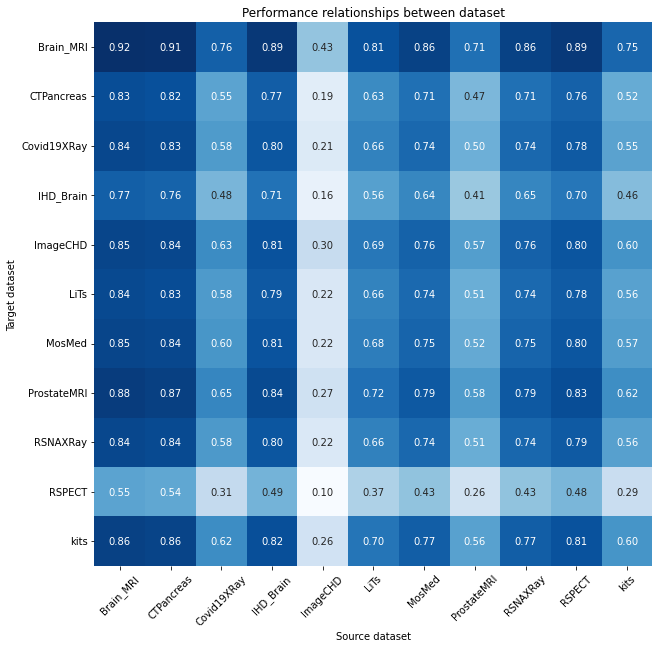

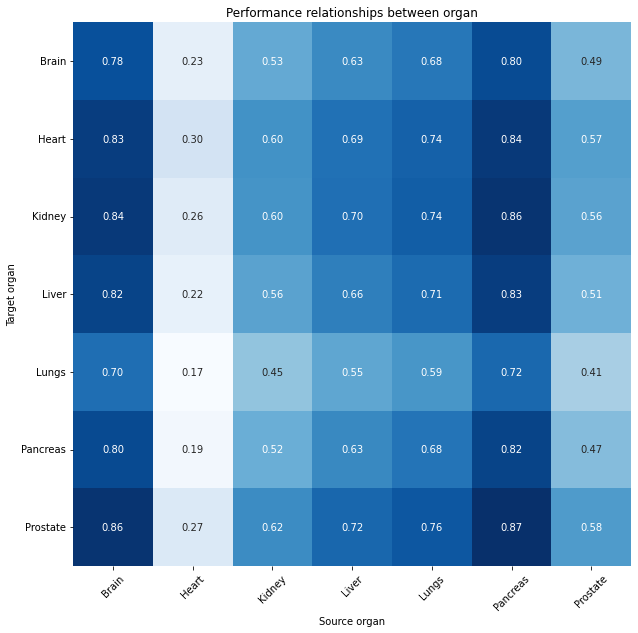

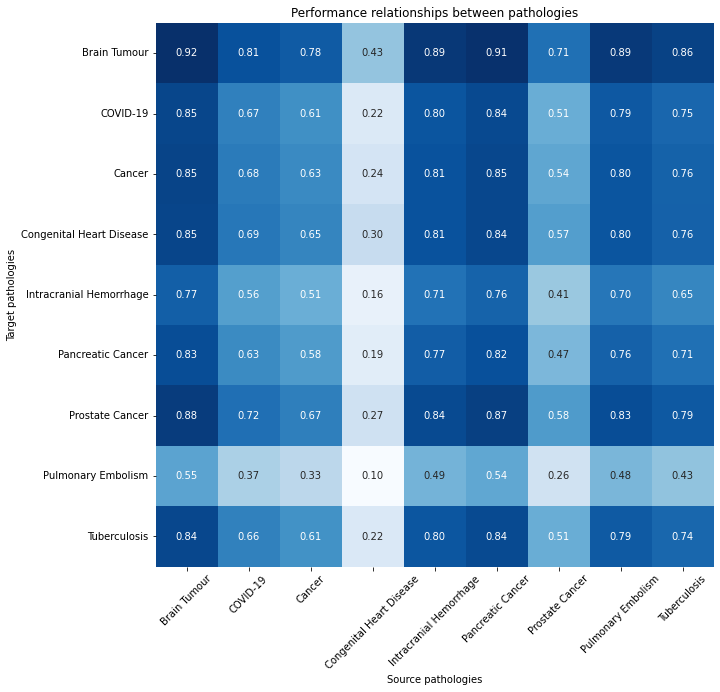

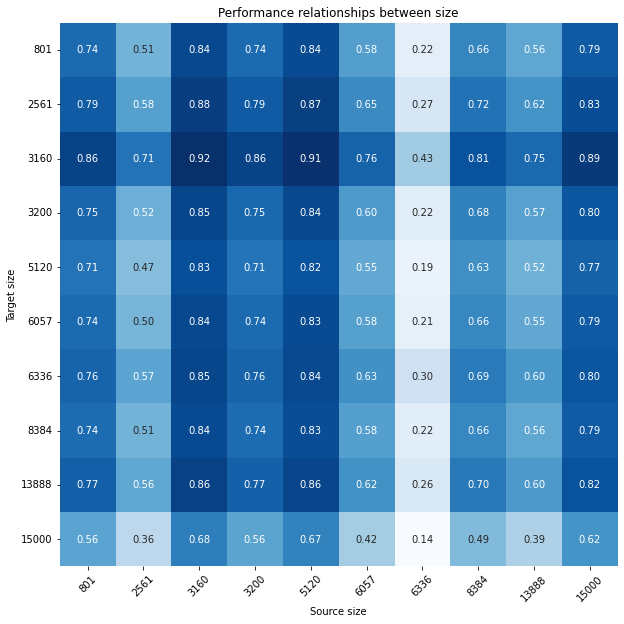

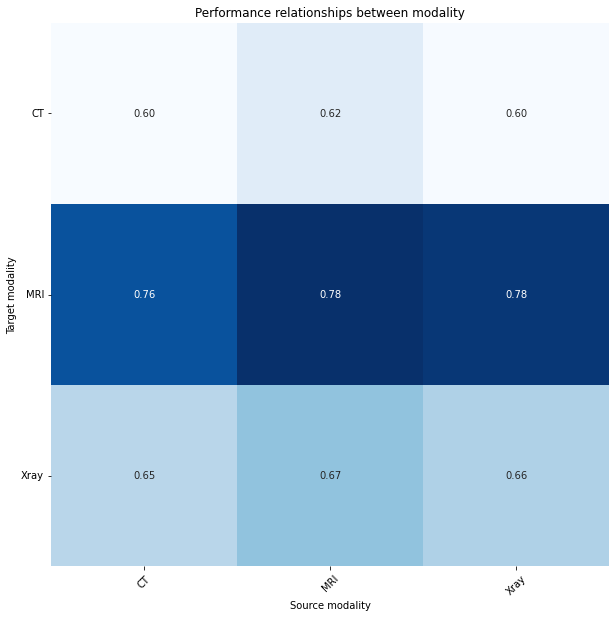

In [ ]:
for bucket in ['dataset','organ', 'pathologies', 'size', 'modality']:
    plot_heatmap(get_bucket(d_d, bucket).unstack(), title = f'Performance relationships between {bucket}', x_label = f'Source {bucket}', y_label = f'Target {bucket}')

In [48]:
# Visualize the pred_f1 for each source_organ and target_organ pair
import matplotlib.pyplot as plt
import seaborn as sns

def plot_heatmap(df, ax=None, figsize=(10, 10), cmap='viridis', vmin=0, vmax=1):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(df, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xlabel('Target Organ')
    ax.set_ylabel('Source Organ')
    ax.set_title('Predicted F1 Score')
    return ax

In [49]:
# Plot heatmap for fil with pred_f1 as values and source_organ as x-axis and target_organ as y-axis 
import seaborn as sns
sns.set(style="whitegrid")
sns.set(font_scale=1.5)
sns.set_context("talk")

def plot_heatmap(fil, x_label, y_label, title, cmap = 'RdYlGn'):
    sns.heatmap(fil, xticklabels=fil[x_label].unique(), yticklabels=fil[y_label].unique(), cmap=cmap)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [50]:
plot_heatmap(fil, 'source_organ', 'target_organ', 'Predicted F1')

NameError: name 'fil' is not defined

In [ ]:
my_preds.groupby(['dataset','target_dataset']).agg({'pred_f1':'mean'})['pred_f1']

NameError: name 'my_preds' is not defined

In [ ]:
d_d = my_preds.groupby(['dataset','target_dataset']).agg({'pred_f1':'mean'})['pred_f1'].reset_index()

NameError: name 'my_preds' is not defined

In [ ]:
def filter(final_emb_list, groupby = 'organ', emb= 'avg', dist_from = 'emb'):
    # By dataset
    
    dataset_only = final_emb_list[['dataset',dist_from]].groupby('dataset').mean()
    if groupby == 'dataset':
        return dataset_only
    temp = final_emb_list[final_emb_list['type'] == 'data']
    # Join of temp and dataset_only using column 'dataset'
    temp = temp.join(dataset_only, on='dataset', how='inner', lsuffix='', rsuffix='_globalavg')

    if emb =='avg':
        x = temp[[groupby,f'{dist_from}_globalavg']].groupby(groupby).mean()
        x.rename(columns={f'{dist_from}_globalavg': f'{dist_from}'}, inplace=True)
        return x
    # rename column
    else:
        return temp[[groupby, dist_from]].groupby(groupby).mean()

# Distance matrix calculation
def get_distances(d, dist_from = 'emb'):
    embs = np.array([list(x) for x in d[dist_from].to_list()])
    #print(embs.shape)
    #print(distances)
    labels = list(d.index)
    # calculate euclidian distance matrix
    return squareform(pdist(embs, 'euclidean')), labels

# Matrix to pairwise source, target distance list
def matrix_to_pairwise(distances):
    mat = []
    for i in range(len(distances)):
        for j in range(len(distances)):
            mat.append({'source': labels[i], 'target': labels[j], 'weight': distances[i][j]})
    return pd.DataFrame(mat)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Visualize distance matrix
def visualize_distances(distances, labels, title, log_scale = False):
    plt.figure(figsize=(15,15))
    # try a more diverging cmap color
    plt.imshow(np.log(distances) if log_scale else distances, cmap=plt.cm.RdBu, interpolation=None)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.title(title)
    plt.show()

# To visualize the embeddings as a plot again. For average bucket.
# labels = list(dataset_only[dist_from].index)
# embeddings = list(dataset_only[dist_from].values)
# embeddings = np.array([list(x) for x in embeddings]

## Predicted Performance Bucketing

In [51]:
d_m

,target_dataset,pred_f1,best_epoch,f1,loss,model_path,dataset,model,with_aug,balanced,pretrained,batch_128,topn,f_emb
0,MosMed,0.7250571,84,0.788686,0.435503,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
1,MosMed,0.7470223,75,0.800681,0.426641,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,MosMed,0.7568937,92,0.788177,0.400816,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
3,MosMed,0.36537516,46,0.452632,0.278173,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet18,False,False,False,False,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4,MosMed,0.73817515,97,0.790698,0.439231,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,IHD_Brain,resnet50,True,True,False,True,top-2,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5231,RSNAXRay,0.72009283,44,0.702703,0.143112,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,MosMed,resnet18,True,False,False,False,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(2...."
5232,RSNAXRay,0.73420566,59,0.544178,1.145104,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Covid19XRay,densenet121,True,False,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
5233,RSNAXRay,0.71810865,85,0.530511,0.094970,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,kits,resnet50,True,True,False,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
5234,RSNAXRay,0.7420287,88,0.531792,1.122675,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,Covid19XRay,resnet18,True,False,True,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."


In [52]:
def filter(groupby = 'organ', emb= 'avg', dist_from = 'emb'):
    # By dataset
    
    dataset_only = final_emb_list[['dataset',dist_from]].groupby('dataset').mean()
    if groupby == 'dataset':
        return dataset_only
    temp = final_emb_list[final_emb_list['type'] == 'data']
    # Join of temp and dataset_only using column 'dataset'
    temp = temp.join(dataset_only, on='dataset', how='inner', lsuffix='', rsuffix='_globalavg')

    if emb =='avg':
        x = temp[[groupby,f'{dist_from}_globalavg']].groupby(groupby).mean()
        x.rename(columns={f'{dist_from}_globalavg': f'{dist_from}'}, inplace=True)
        return x
    # rename column
    else:
        return temp[[groupby, dist_from]].groupby(groupby).mean()

# Distance matrix calculation
def get_distances(d, dist_from = 'emb'):
    embs = np.array([list(x) for x in d[dist_from].to_list()])
    #print(embs.shape)
    #print(distances)
    labels = list(d.index)
    # calculate euclidian distance matrix
    return squareform(pdist(embs, 'euclidean')), labels

# Matrix to pairwise source, target distance list
def matrix_to_pairwise(distances):
    mat = []
    for i in range(len(distances)):
        for j in range(len(distances)):
            mat.append({'source': labels[i], 'target': labels[j], 'weight': distances[i][j]})
    return pd.DataFrame(mat)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Visualize distance matrix
def visualize_distances(distances, labels, title, log_scale = False):
    plt.figure(figsize=(15,15))
    # try a more diverging cmap color
    plt.imshow(np.log(distances) if log_scale else distances, cmap=plt.cm.RdBu, interpolation=None)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.title(title)
    plt.show()

# To visualize the embeddings as a plot again. For average bucket.
# labels = list(dataset_only[dist_from].index)
# embeddings = list(dataset_only[dist_from].values)
# embeddings = np.array([list(x) for x in embeddings]

mean, std : (0.16189234127213195, 0.16484129624616373)

mse:0.053381783110687954

## Visualizations below

In [53]:
import pandas as pd
pd.DataFrame(data_emb_list)

,name,emb,dataset,color,type,organ,pathologies,location,size,modality,...,f1,loss,model_path,model,with_aug,balanced,pretrained,batch_128,topn,f_emb
0,MosMed,"[-0.09513576, -0.07498257, 0.018053403, -0.004...",MosMed,1,data,Lungs,COVID-19,[Russia],3200.0,CT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M_0.77,"[-0.041001327, -0.011824959, -0.036100432, -0....",MosMed,1,model,NaN,NaN,NaN,NaN,NaN,...,0.768421,0.074524,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,mobilenet_v2,True,True,False,True,top-7,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,M_0.81,"[-0.032405473, -0.030662633, -0.0034572429, -0...",MosMed,1,model,NaN,NaN,NaN,NaN,NaN,...,0.806202,0.170831,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,efficientnet_b4,True,False,False,False,top-7,"[tensor(0.0108), tensor(0.0750), tensor(0.0112..."
3,M_0.70,"[-0.0613609, 0.00025926784, -0.028130552, -0.0...",MosMed,1,model,NaN,NaN,NaN,NaN,NaN,...,0.703252,0.430663,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,densenet121,True,True,False,True,top-7,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4,M_0.76,"[-0.05240414, -0.054933082, 0.027191985, -0.08...",MosMed,1,model,NaN,NaN,NaN,NaN,NaN,...,0.764286,0.126464,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,mobilenet_v2,False,False,False,False,top-7,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,M_0.74,"[0.064141855, 0.10252589, -0.15254916, 0.06292...",RSNAXRay,11,model,NaN,NaN,NaN,NaN,NaN,...,0.744828,0.542110,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,densenet121,True,False,False,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
483,M_0.64,"[0.021423113, 0.18113606, -0.10310141, 0.03988...",RSNAXRay,11,model,NaN,NaN,NaN,NaN,NaN,...,0.637255,2.097646,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,efficientnet_b4,True,False,False,True,raw,"[tensor(217.7893), tensor(-0.0106), tensor(19...."
484,M_0.77,"[-0.0011156572, 0.09980263, -0.047153402, 0.01...",RSNAXRay,11,model,NaN,NaN,NaN,NaN,NaN,...,0.772152,1.330657,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,efficientnet_b4,True,True,True,True,raw,"[tensor(-0.1437), tensor(-0.1512), tensor(-0.1..."
485,M_0.72,"[0.00408792, 0.13673158, -0.044844892, 0.05257...",RSNAXRay,11,model,NaN,NaN,NaN,NaN,NaN,...,0.719212,1.303484,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,efficientnet_b4,True,True,False,True,raw,"[tensor(0.1170), tensor(0.0038), tensor(0.0715..."


In [54]:
# Do T-sne visualization of the embeddings in data_emb_list
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE, LocallyLinearEmbedding, LocallyLinearEmbedding, SpectralEmbedding, MDS, Isomap
from sklearn.decomposition import PCA

# Visualize embeddings
def visualize_embeddings(data_emb_list, title, method, return_emb=True):
    
    colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'indigo', 'lime', 'olive', 'teal', 'navy', 'maroon', 'black', 'gold', 'silver', 'gray', 'crimson', 'darkblue', 'darkgreen', 'darkred', 'darkorange', 'darkviolet', 'darkcyan', 'darkmagenta', 'darkgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray']

    # Visualize embeddings
    if method == 'tsne':
        tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
        results = tsne.fit_transform([d['emb'] for d in data_emb_list])
    elif method == 'pca':
        pca = PCA(n_components=2)
        results = pca.fit_transform([d['emb'] for d in data_emb_list])
        # print explained variance
        print('explained variance ratio (first two components): %s' % str(pca.explained_variance_ratio_))
        
    elif method =='isomap':
        isomap = Isomap(n_components=2)
        results = isomap.fit_transform([d['emb'] for d in data_emb_list])
    elif method == 'lle': 
        lle = LocallyLinearEmbedding(n_components=2)
        results = lle.fit_transform([d['emb'] for d in data_emb_list])

    if return_emb:
        return results
        
    plt.figure(figsize=(20, 20))
    
    for i, d in enumerate(data_emb_list):
        x, y = results[i, :]
        plt.scatter(x, y, c=colors[d['color']-1], s=50)
        plt.annotate(d['name'] if 'M_' not in d['name'] else '', (x, y), fontsize=18 if 'M_' not in d['name'] else 9, color=colors[d['color']-1] if 'M_' not in d['name'] else 'black')
    plt.title(title)
    plt.show()

d = dict()
return_emb = True
d['pca'] = visualize_embeddings(data_emb_list, 'PCA', 'pca', return_emb=return_emb)
d['tsne'] = visualize_embeddings(data_emb_list, 't-SNE', 'tsne', return_emb=return_emb)
d['isomap'] = visualize_embeddings(data_emb_list, 'Isomap', 'isomap', return_emb=return_emb)
d['lle'] = visualize_embeddings(data_emb_list, 'Locally Linear Embedding', 'lle', return_emb=return_emb)
import pandas as pd
true = pd.DataFrame(data_emb_list)
true_emb = np.array(pd.DataFrame(true['emb']).values.tolist()).squeeze(1)

explained variance ratio (first two components): [0.23942041 0.19779355]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 487 samples in 0.000s...
[t-SNE] Computed neighbors for 487 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 487 / 487
[t-SNE] Mean sigma: 0.301557


/nfs/users/ext_shikhar.srivastava/miniconda3/envs/ofa/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/nfs/users/ext_shikhar.srivastava/miniconda3/envs/ofa/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.228401
[t-SNE] KL divergence after 300 iterations: 0.282314


/nfs/users/ext_shikhar.srivastava/miniconda3/envs/ofa/lib/python3.8/site-packages/sklearn/manifold/_isomap.py:324: UserWarning: The number of connected components of the neighbors graph is 12 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/nfs/users/ext_shikhar.srivastava/miniconda3/envs/ofa/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/nfs/users/ext_shikhar.srivastava/miniconda3/envs/ofa/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/nfs/users/ext_shikhar.srivastava/miniconda3/envs/ofa/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Cha

In [55]:
# Compute the distance matrix
from scipy.spatial.distance import pdist, squareform

def compute_distances(emb):
    return squareform(pdist(emb, 'euclidean'))
    # Calculate euclidian error between two distance matrices
def euclidian_error(true_distances, distances):
    return np.sqrt(np.sum(np.square(true_distances - distances)))
# Compute the distance matrix for true_emb
true_distances = compute_distances(true_emb)
viz_d = dict()
for key, value in d.items():
    viz_d[key] = compute_distances(value)
# iterate over all d methods and print euclidian error
for key, value in viz_d.items():
    print('Euclidian error for %s: %.2f'%(key, euclidian_error(true_distances, value)))

Euclidian error for pca: 275.26
Euclidian error for tsne: 7056.39
Euclidian error for isomap: 402.77
Euclidian error for lle: 600.90


# Final Visualizations

In [56]:
final_emb_list = pd.DataFrame(data_emb_list.copy())
final_emb_list['pca'] = list(d['pca'])
final_emb_list['tsne'] = list(d['tsne'])
final_emb_list['isomap'] = list(d['isomap'])
final_emb_list['lle'] = list(d['lle'])

In [57]:
final_emb_list

,name,emb,dataset,color,type,organ,pathologies,location,size,modality,...,with_aug,balanced,pretrained,batch_128,topn,f_emb,pca,tsne,isomap,lle
0,MosMed,"[-0.09513576, -0.07498257, 0.018053403, -0.004...",MosMed,1,data,Lungs,COVID-19,[Russia],3200.0,CT,...,NaN,NaN,NaN,NaN,NaN,NaN,"[1.056522065427374, -0.10421130023948719]","[-7.7173963, 1.380277]","[-0.9457337137779205, -1.8733280800889198]","[6.3482716290234384e-18, 5.881346611251348e-18]"
1,M_0.77,"[-0.041001327, -0.011824959, -0.036100432, -0....",MosMed,1,model,NaN,NaN,NaN,NaN,NaN,...,True,True,False,True,top-7,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[1.039416335329978, 0.019704200379859284]","[-7.1572604, 1.8093191]","[-0.7871288790320518, -2.110025842823606]","[2.7132080349249163e-18, -2.0760209583632444e-18]"
2,M_0.81,"[-0.032405473, -0.030662633, -0.0034572429, -0...",MosMed,1,model,NaN,NaN,NaN,NaN,NaN,...,True,False,False,False,top-7,"[tensor(0.0108), tensor(0.0750), tensor(0.0112...","[0.9829008051411792, -0.057371225404828564]","[-7.365915, 2.1835651]","[0.14670793081488642, -1.330453238548214]","[1.1387084078143221e-18, -2.092391762606068e-18]"
3,M_0.70,"[-0.0613609, 0.00025926784, -0.028130552, -0.0...",MosMed,1,model,NaN,NaN,NaN,NaN,NaN,...,True,True,False,True,top-7,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[0.940026735872954, -0.2546521837159315]","[-7.412397, 2.640684]","[-0.7515586739940558, -1.5336439618488455]","[-2.3550083257812523e-19, -3.1180159881119087e..."
4,M_0.76,"[-0.05240414, -0.054933082, 0.027191985, -0.08...",MosMed,1,model,NaN,NaN,NaN,NaN,NaN,...,False,False,False,False,top-7,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[1.0039376657067032, -0.22827596526213656]","[-7.591737, 2.243667]","[-0.6956215692256837, -1.4849211969265208]","[2.6092828439187075e-18, -1.8495922559373103e-19]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,M_0.74,"[0.064141855, 0.10252589, -0.15254916, 0.06292...",RSNAXRay,11,model,NaN,NaN,NaN,NaN,NaN,...,True,False,False,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[0.26286607712985943, 0.8179857082184692]","[0.77531064, -1.7700806]","[0.2500637393532155, -1.040949150631059]","[-3.3867158711163006e-17, 2.750554523353979e-17]"
483,M_0.64,"[0.021423113, 0.18113606, -0.10310141, 0.03988...",RSNAXRay,11,model,NaN,NaN,NaN,NaN,NaN,...,True,False,False,True,raw,"[tensor(217.7893), tensor(-0.0106), tensor(19....","[0.14979333449934068, 0.8261232042107023]","[0.8084393, -1.7822168]","[0.18380184867037022, -0.7111853695366511]","[-3.383746726247755e-17, 4.144337557031579e-17]"
484,M_0.77,"[-0.0011156572, 0.09980263, -0.047153402, 0.01...",RSNAXRay,11,model,NaN,NaN,NaN,NaN,NaN,...,True,True,True,True,raw,"[tensor(-0.1437), tensor(-0.1512), tensor(-0.1...","[0.20504401942024916, 0.42061335247666987]","[0.6041963, -1.4410696]","[-1.0080091790790577, 0.020544740924035645]","[-3.874060459611713e-17, 2.5979419920965017e-17]"
485,M_0.72,"[0.00408792, 0.13673158, -0.044844892, 0.05257...",RSNAXRay,11,model,NaN,NaN,NaN,NaN,NaN,...,True,True,False,True,raw,"[tensor(0.1170), tensor(0.0038), tensor(0.0715...","[0.2848534309739513, 0.7348379376216243]","[0.72526777, -1.6582355]","[-0.2213404689026569, -0.6869060458614643]","[-2.2086168416371724e-17, 2.778739480757731e-17]"


In [58]:
final_emb_list.columns

Index(['name', 'emb', 'dataset', 'color', 'type', 'organ', 'pathologies',
       'location', 'size', 'modality', 'classes', 'best_epoch', 'f1', 'loss',
       'model_path', 'model', 'with_aug', 'balanced', 'pretrained',
       'batch_128', 'topn', 'f_emb', 'pca', 'tsne', 'isomap', 'lle'],
      dtype='object')

In [59]:
# Only datasets
only_datasets = final_emb_list[final_emb_list['type'] == 'data'].reset_index(drop=True)
only_datasets

,name,emb,dataset,color,type,organ,pathologies,location,size,modality,...,with_aug,balanced,pretrained,batch_128,topn,f_emb,pca,tsne,isomap,lle
0,MosMed,"[-0.09513576, -0.07498257, 0.018053403, -0.004...",MosMed,1,data,Lungs,COVID-19,[Russia],3200.0,CT,...,NaN,NaN,NaN,NaN,NaN,NaN,"[1.056522065427374, -0.10421130023948719]","[-7.7173963, 1.380277]","[-0.9457337137779205, -1.8733280800889198]","[6.3482716290234384e-18, 5.881346611251348e-18]"
1,Brain_MRI,"[0.062318858, -0.09616479, 0.14780201, 0.06124...",Brain_MRI,2,data,Brain,Brain Tumour,[Global],3160.0,MRI,...,NaN,NaN,NaN,NaN,NaN,NaN,"[0.10892423495784433, 0.08674440077492758]","[7.4288697, 4.295551]","[-0.49692679350559466, -1.157828854111882]","[-2.711754978034165e-18, -1.923281750988846e-18]"
2,ImageCHD,"[0.05938457, -0.11358652, -0.031441122, 0.0656...",ImageCHD,3,data,Heart,Congenital Heart Disease,[China],6336.0,CT,...,NaN,NaN,NaN,NaN,NaN,NaN,"[0.20591374407484575, 0.6412178795246002]","[5.0818233, -2.7359233]","[0.5927826556938725, -1.041760068340604]","[-7.964796497009618e-19, -3.3652631856704916e-18]"
3,LiTs,"[-0.07120009, -0.024767144, 0.07089626, -0.059...",LiTs,4,data,Liver,Cancer,"[Germany, Netherlands, Canada, Israel]",8384.0,CT,...,NaN,NaN,NaN,NaN,NaN,NaN,"[0.2756702271783338, -0.595742235923969]","[-13.352908, 8.948369]","[-1.225182870071936, 0.1940264333365957]","[-3.63758451304982e-18, -3.6569847729888975e-18]"
4,ProstateMRI,"[0.024737507, 0.09088361, 0.02115894, 0.092811...",ProstateMRI,5,data,Prostate,Prostate Cancer,[USA],2561.0,MRI,...,NaN,NaN,NaN,NaN,NaN,NaN,"[0.44804199513590903, 0.5262629854607189]","[0.01987157, 1.502019]","[0.06817206522305502, -1.3011519503337232]","[-1.3064843100892617e-17, -1.7912713118000745e..."
5,Covid19XRay,"[0.08144808, 0.06834437, -0.074965514, 0.01705...",Covid19XRay,6,data,Lungs,COVID-19,"[Spain, USA]",6057.0,Xray,...,NaN,NaN,NaN,NaN,NaN,NaN,"[0.16835350317764253, 0.23332199430744854]","[-2.7854793, -5.168244]","[0.21594013076747803, -0.15946063369245222]","[0.1690308509456455, -6.962755083829925e-19]"
6,IHD_Brain,"[0.13933699, -0.01761837, 0.053443808, 0.01992...",IHD_Brain,7,data,Brain,Intracranial Hemorrhage,"[USA, Brazil]",15000.0,CT,...,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.3801848053068513, 0.2957815493598391]","[12.19589, -2.7159822]","[1.8490502747941555, 0.41416010686280214]","[2.2752554289206433e-18, 0.10482848367219189]"
7,CTPancreas,"[-0.030812759, 0.08818435, -0.05367696, -0.027...",CTPancreas,8,data,Pancreas,Pancreatic Cancer,[USA],5120.0,CT,...,NaN,NaN,NaN,NaN,NaN,NaN,"[0.5372165186344964, 0.14733985227442303]","[-10.17933, -5.014018]","[0.14056316263498353, -1.1477561303276844]","[8.515071477387018e-18, 5.611188990150641e-18]"
8,RSPECT,"[0.11149377, 0.112761796, -0.13529092, -0.0884...",RSPECT,9,data,Lungs,Pulmonary Embolism,"[Australia, Turkey, USA, Canada, Brazil]",15000.0,CT,...,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.06507647945786574, 0.20487964769192618]","[1.1413453, -13.086367]","[-0.008515287553471366, -0.2135965337614363]","[6.194583637016621e-18, -2.8478605180337973e-19]"
9,kits,"[-0.005594138, -0.0095899, 0.07248677, -0.0492...",kits,10,data,Kidney,Cancer,[USA],13888.0,CT,...,NaN,NaN,NaN,NaN,NaN,NaN,"[-0.4420801855991607, -0.5233310653323153]","[2.4161804, 10.381636]","[-1.172648055050645, 1.6589079342361868]","[-2.063465848121863e-18, -1.5684768629810151e-18]"


In [60]:
def convert_to_df(grouped, columns = ['name','emb']):
    # Convert dictionary to dataframe with columns as keys and values as values
    new_dict = dict()
    for key, value in grouped.to_dict()['emb'].items():
        new_dict[key] = [value]
    return pd.DataFrame.from_dict(new_dict, orient='index')

# Make index another column
only_datasets = convert_to_df(only_datasets)
#only_datasets['name'] = only_datasets.index
#only_datasets = only_datasets.reset_index(drop=True)
only_datasets

,0
0,"[-0.09513576, -0.07498257, 0.018053403, -0.004..."
1,"[0.062318858, -0.09616479, 0.14780201, 0.06124..."
2,"[0.05938457, -0.11358652, -0.031441122, 0.0656..."
3,"[-0.07120009, -0.024767144, 0.07089626, -0.059..."
4,"[0.024737507, 0.09088361, 0.02115894, 0.092811..."
5,"[0.08144808, 0.06834437, -0.074965514, 0.01705..."
6,"[0.13933699, -0.01761837, 0.053443808, 0.01992..."
7,"[-0.030812759, 0.08818435, -0.05367696, -0.027..."
8,"[0.11149377, 0.112761796, -0.13529092, -0.0884..."
9,"[-0.005594138, -0.0095899, 0.07248677, -0.0492..."


In [61]:
d = filter(groupby='organ', emb='avg', dist_from='emb')
embs = np.array([list(x) for x in d['emb'].to_list()])
d.shape

(7, 1)

In [62]:
d

,emb
organ,
Brain,"[0.09283688, -0.0065149274, 0.06850109, -0.000..."
Heart,"[0.035983246, -0.059230357, -0.06632869, 0.020..."
Kidney,"[0.020855857, 0.045537785, 0.032275997, -0.076..."
Liver,"[-0.048832417, 0.055672646, 0.046073906, -0.13..."
Lungs,"[0.032202017, 0.07232298, -0.072017744, -0.020..."
Pancreas,"[-0.009392185, 0.15041806, -0.06311625, -0.073..."
Prostate,"[0.011588872, 0.18148483, 0.0071802437, 0.0079..."


In [63]:

pdist(embs, 'euclidean').shape

(21,)

In [64]:
final_emb_list.columns

Index(['name', 'emb', 'dataset', 'color', 'type', 'organ', 'pathologies',
       'location', 'size', 'modality', 'classes', 'best_epoch', 'f1', 'loss',
       'model_path', 'model', 'with_aug', 'balanced', 'pretrained',
       'batch_128', 'topn', 'f_emb', 'pca', 'tsne', 'isomap', 'lle'],
      dtype='object')

In [65]:
dist_from='pca'


In [66]:
def filter(groupby = 'organ', emb= 'avg', dist_from = 'emb'):
    # By dataset
    
    dataset_only = final_emb_list[['dataset',dist_from]].groupby('dataset').mean()
    if groupby == 'dataset':
        return dataset_only
    temp = final_emb_list[final_emb_list['type'] == 'data']
    # Join of temp and dataset_only using column 'dataset'
    temp = temp.join(dataset_only, on='dataset', how='inner', lsuffix='', rsuffix='_globalavg')

    if emb =='avg':
        x = temp[[groupby,f'{dist_from}_globalavg']].groupby(groupby).mean()
        x.rename(columns={f'{dist_from}_globalavg': f'{dist_from}'}, inplace=True)
        return x
    # rename column
    else:
        return temp[[groupby, dist_from]].groupby(groupby).mean()

# Distance matrix calculation
def get_distances(d, dist_from = 'emb', condensed = False):
    embs = np.array([list(x) for x in d[dist_from].to_list()])
    #print(embs.shape)
    #print(distances)
    labels = list(d.index)
    # calculate euclidian distance matrix
    if condensed:
        return pdist(embs, 'euclidean'), labels
    return squareform(pdist(embs, 'euclidean')), labels

# Matrix to pairwise source, target distance list
def matrix_to_pairwise(distances):
    mat = []
    for i in range(len(distances)):
        for j in range(len(distances)):
            mat.append({'source': labels[i], 'target': labels[j], 'weight': distances[i][j]})
    return pd.DataFrame(mat)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Visualize distance matrix
def visualize_distances(distances, labels, title, log_scale = False):
    plt.figure(figsize=(15,15))
    # try a more diverging cmap color
    plt.imshow(np.log(distances) if log_scale else distances, cmap=plt.cm.RdBu, interpolation=None)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.title(title)
    plt.show()

# To visualize the embeddings as a plot again. For average bucket.
# labels = list(dataset_only[dist_from].index)
# embeddings = list(dataset_only[dist_from].values)
# embeddings = np.array([list(x) for x in embeddings]

In [67]:
from scipy.cluster.hierarchy import linkage, dend-rogram
# Visualize dendogram of the embeddings
def visualize_dendogram(distances, labels, title, leaf_rotation = 90):
    # Create linkage matrix
    linkage_matrix = linkage(distances, 'ward')
    # Plot dendrogram
    dendrogram(linkage_matrix, labels=labels, leaf_rotation=leaf_rotation, leaf_font_size=12., color_threshold=0.5)
    plt.title(title)
    plt.show()

SyntaxError: invalid syntax (3261138455.py, line 1)

/tmp/ipykernel_8233/290618698.py:47: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


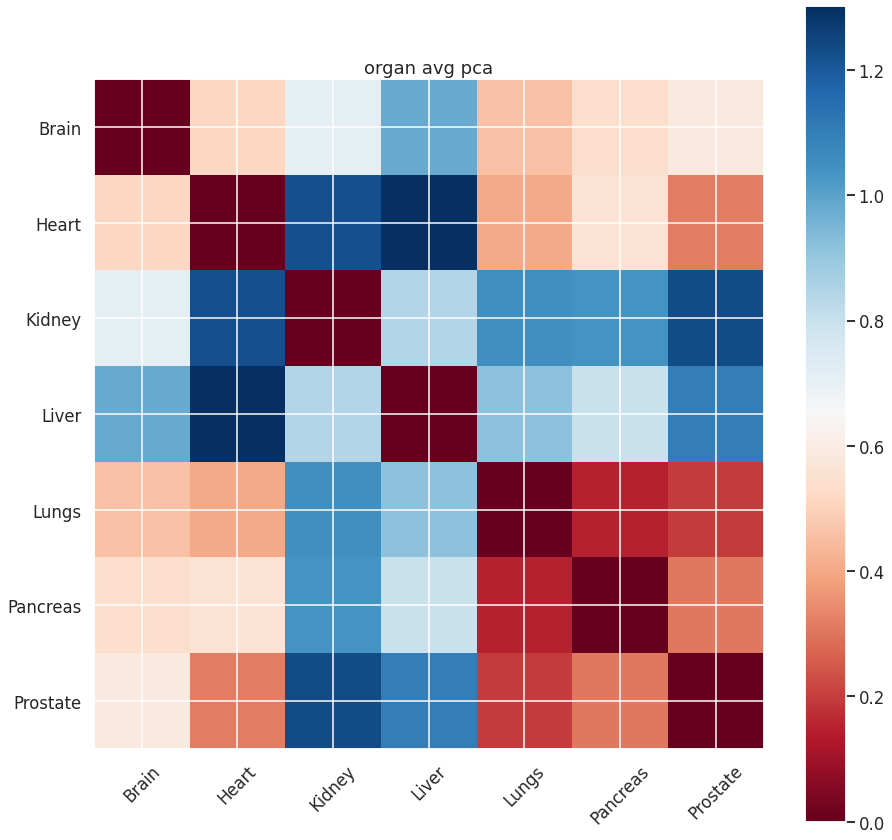

NameError: name 'visualize_dendogram' is not defined

In [68]:
dist_from = ['pca','tsne','emb']
groupby = ['organ', 'dataset', 'pathologies','modality']
type = ['avg','x']
for _dist_from in dist_from:
    for _groupby in groupby:
        for _type in type:
            d = filter(groupby=_groupby, emb=_type, dist_from=_dist_from)
            distances, labels = get_distances(d, dist_from=_dist_from)
            visualize_distances(distances, labels, f'{_groupby} {_type} {_dist_from}')
            visualize_dendogram(distances, labels, f'{_groupby} {_type} {_dist_from}')
#visualize_dendogram(*get_distances(filter(groupby=groupby, emb=type, dist_from=dist_from), dist_from=dist_from), condensed=True), groupby)

In [69]:
visualize_dendogram(*get_distances(filter(groupby='organ', emb='avg', dist_from='emb'), condensed=True), 'Organ')

NameError: name 'visualize_dendogram' is not defined

In [70]:
visualize_dendogram(*get_distances(filter(groupby='dataset', emb='avg', dist_from='emb'), condensed=True), 'Dataset')

NameError: name 'visualize_dendogram' is not defined

In [71]:
visualize_dendogram(*get_distances(filter(groupby='pathologies', emb='avg', dist_from='emb'), condensed=True), 'Pathologies')

NameError: name 'visualize_dendogram' is not defined

In [72]:
visualize_dendogram(*get_distances(filter(groupby='modality', emb='avg', dist_from='emb'), condensed=True), 'Modalities',leaf_rotation = 0)

NameError: name 'visualize_dendogram' is not defined

/tmp/ipykernel_8233/290618698.py:47: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


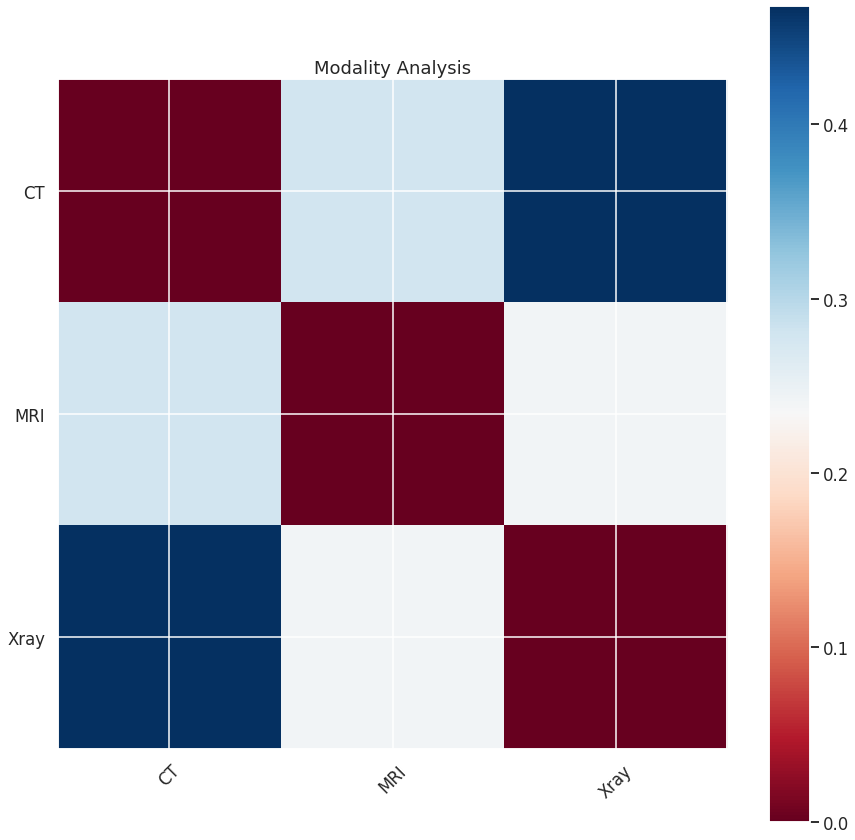

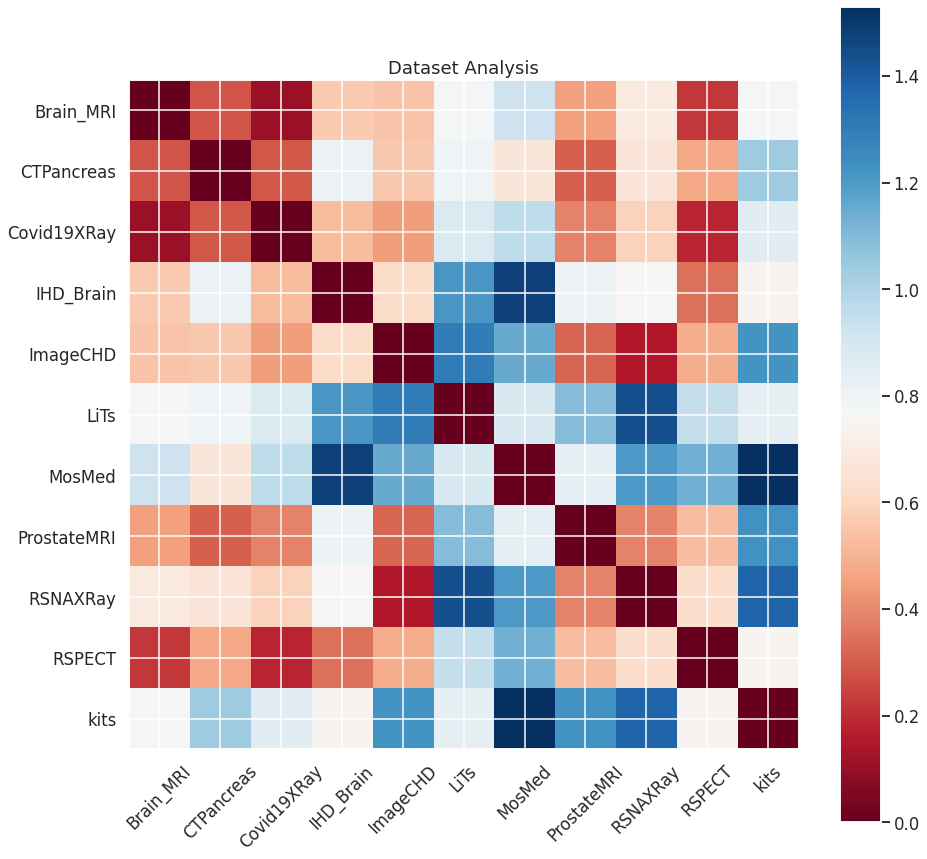

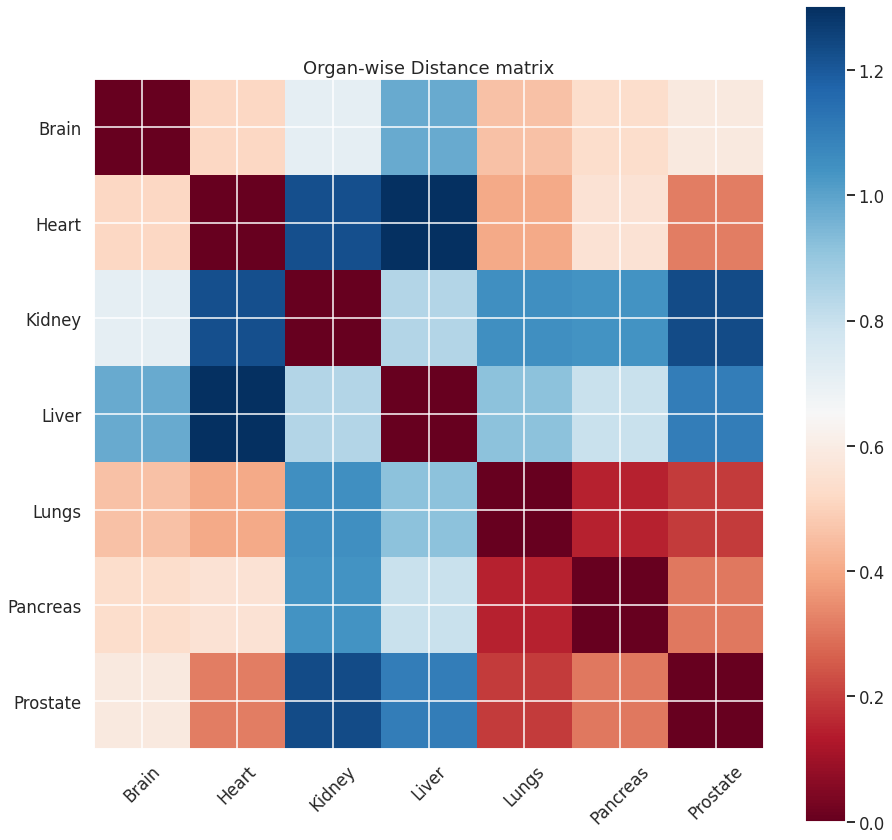

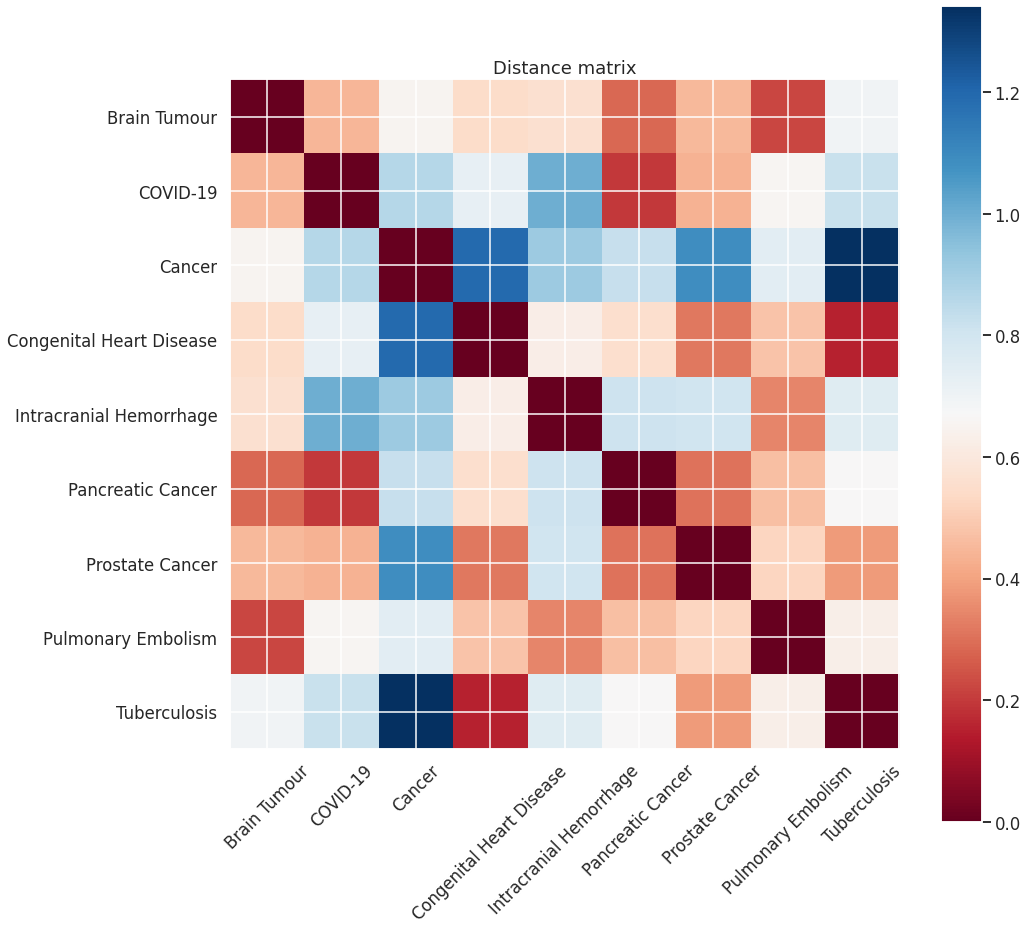

In [73]:
dist_from = 'pca' # 'emb' or 'pca' or 'tsne' or 'isomap' or 'lle'
emb = 'avg' # calculated as avg embedding over all model,dataset embeddings

dataset_only = filter(groupby = 'dataset', emb= emb, dist_from = dist_from)
by_organ = filter(groupby='organ', emb=emb, dist_from = dist_from)
by_modality = filter(groupby='modality', emb=emb, dist_from = dist_from)
by_pathology = filter(groupby='pathologies', emb=emb, dist_from = dist_from)
# Visualize embeddings in a scatterplot
distances, labels = get_distances(by_modality, dist_from = dist_from)
visualize_distances(distances, labels, 'Modality Analysis', log_scale = False)
distances, labels = get_distances(dataset_only, dist_from = dist_from)
visualize_distances(distances, labels, 'Dataset Analysis')
distances, labels = get_distances(by_organ, dist_from = dist_from)
visualize_distances(distances, labels, 'Organ-wise Distance matrix')
distances, labels = get_distances(by_pathology, dist_from = dist_from)
visualize_distances(distances, labels, 'Distance matrix')



results = {'model_zoo': f_model_zoo, 'd_pca': d['pca'], 'd_tsne': d['tsne'], 'd_isomap': d['isomap'], 'd_lle': d['lle'], 'true_distances': true_distances, 'labels_for_distances' : true['dataset']}

torch.save(results, 'results.pt')

torch.load('results.pt')

In [75]:
import d3fdgraph
import pandas as pd
d3fdgraph.plot_force_directed_graph(matrix_to_pairwise(distances))

KeyboardInterrupt: 

In [76]:
# plot distance matrix true_distances with labels true['dataset']
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distances(results):
    plt.figure(figsize=(40, 40))
    sns.heatmap(results['true_distances'], xticklabels=results['labels_for_distances'], yticklabels=results['labels_for_distances'], annot=True, fmt='.2f', cmap='viridis')
    plt.title('True distances')
    plt.show()

In [33]:
plot_distances(results)

In [32]:
def plot_distance_matrix(results, method):
    plt.figure(figsize=(40, 40))
    sns.heatmap(results[method], xticklabels=results['labels_for_distances'], yticklabels=results['labels_for_distances'], annot=True, fmt='.2f', cmap='viridis')
    plt.title('Euclidian error for %s'%method)
    plt.show()

In [ ]:
for method in ['d_pca', 'd_tsne', 'd_isomap', 'd_lle']:
    plot_distance_matrix(results, method)

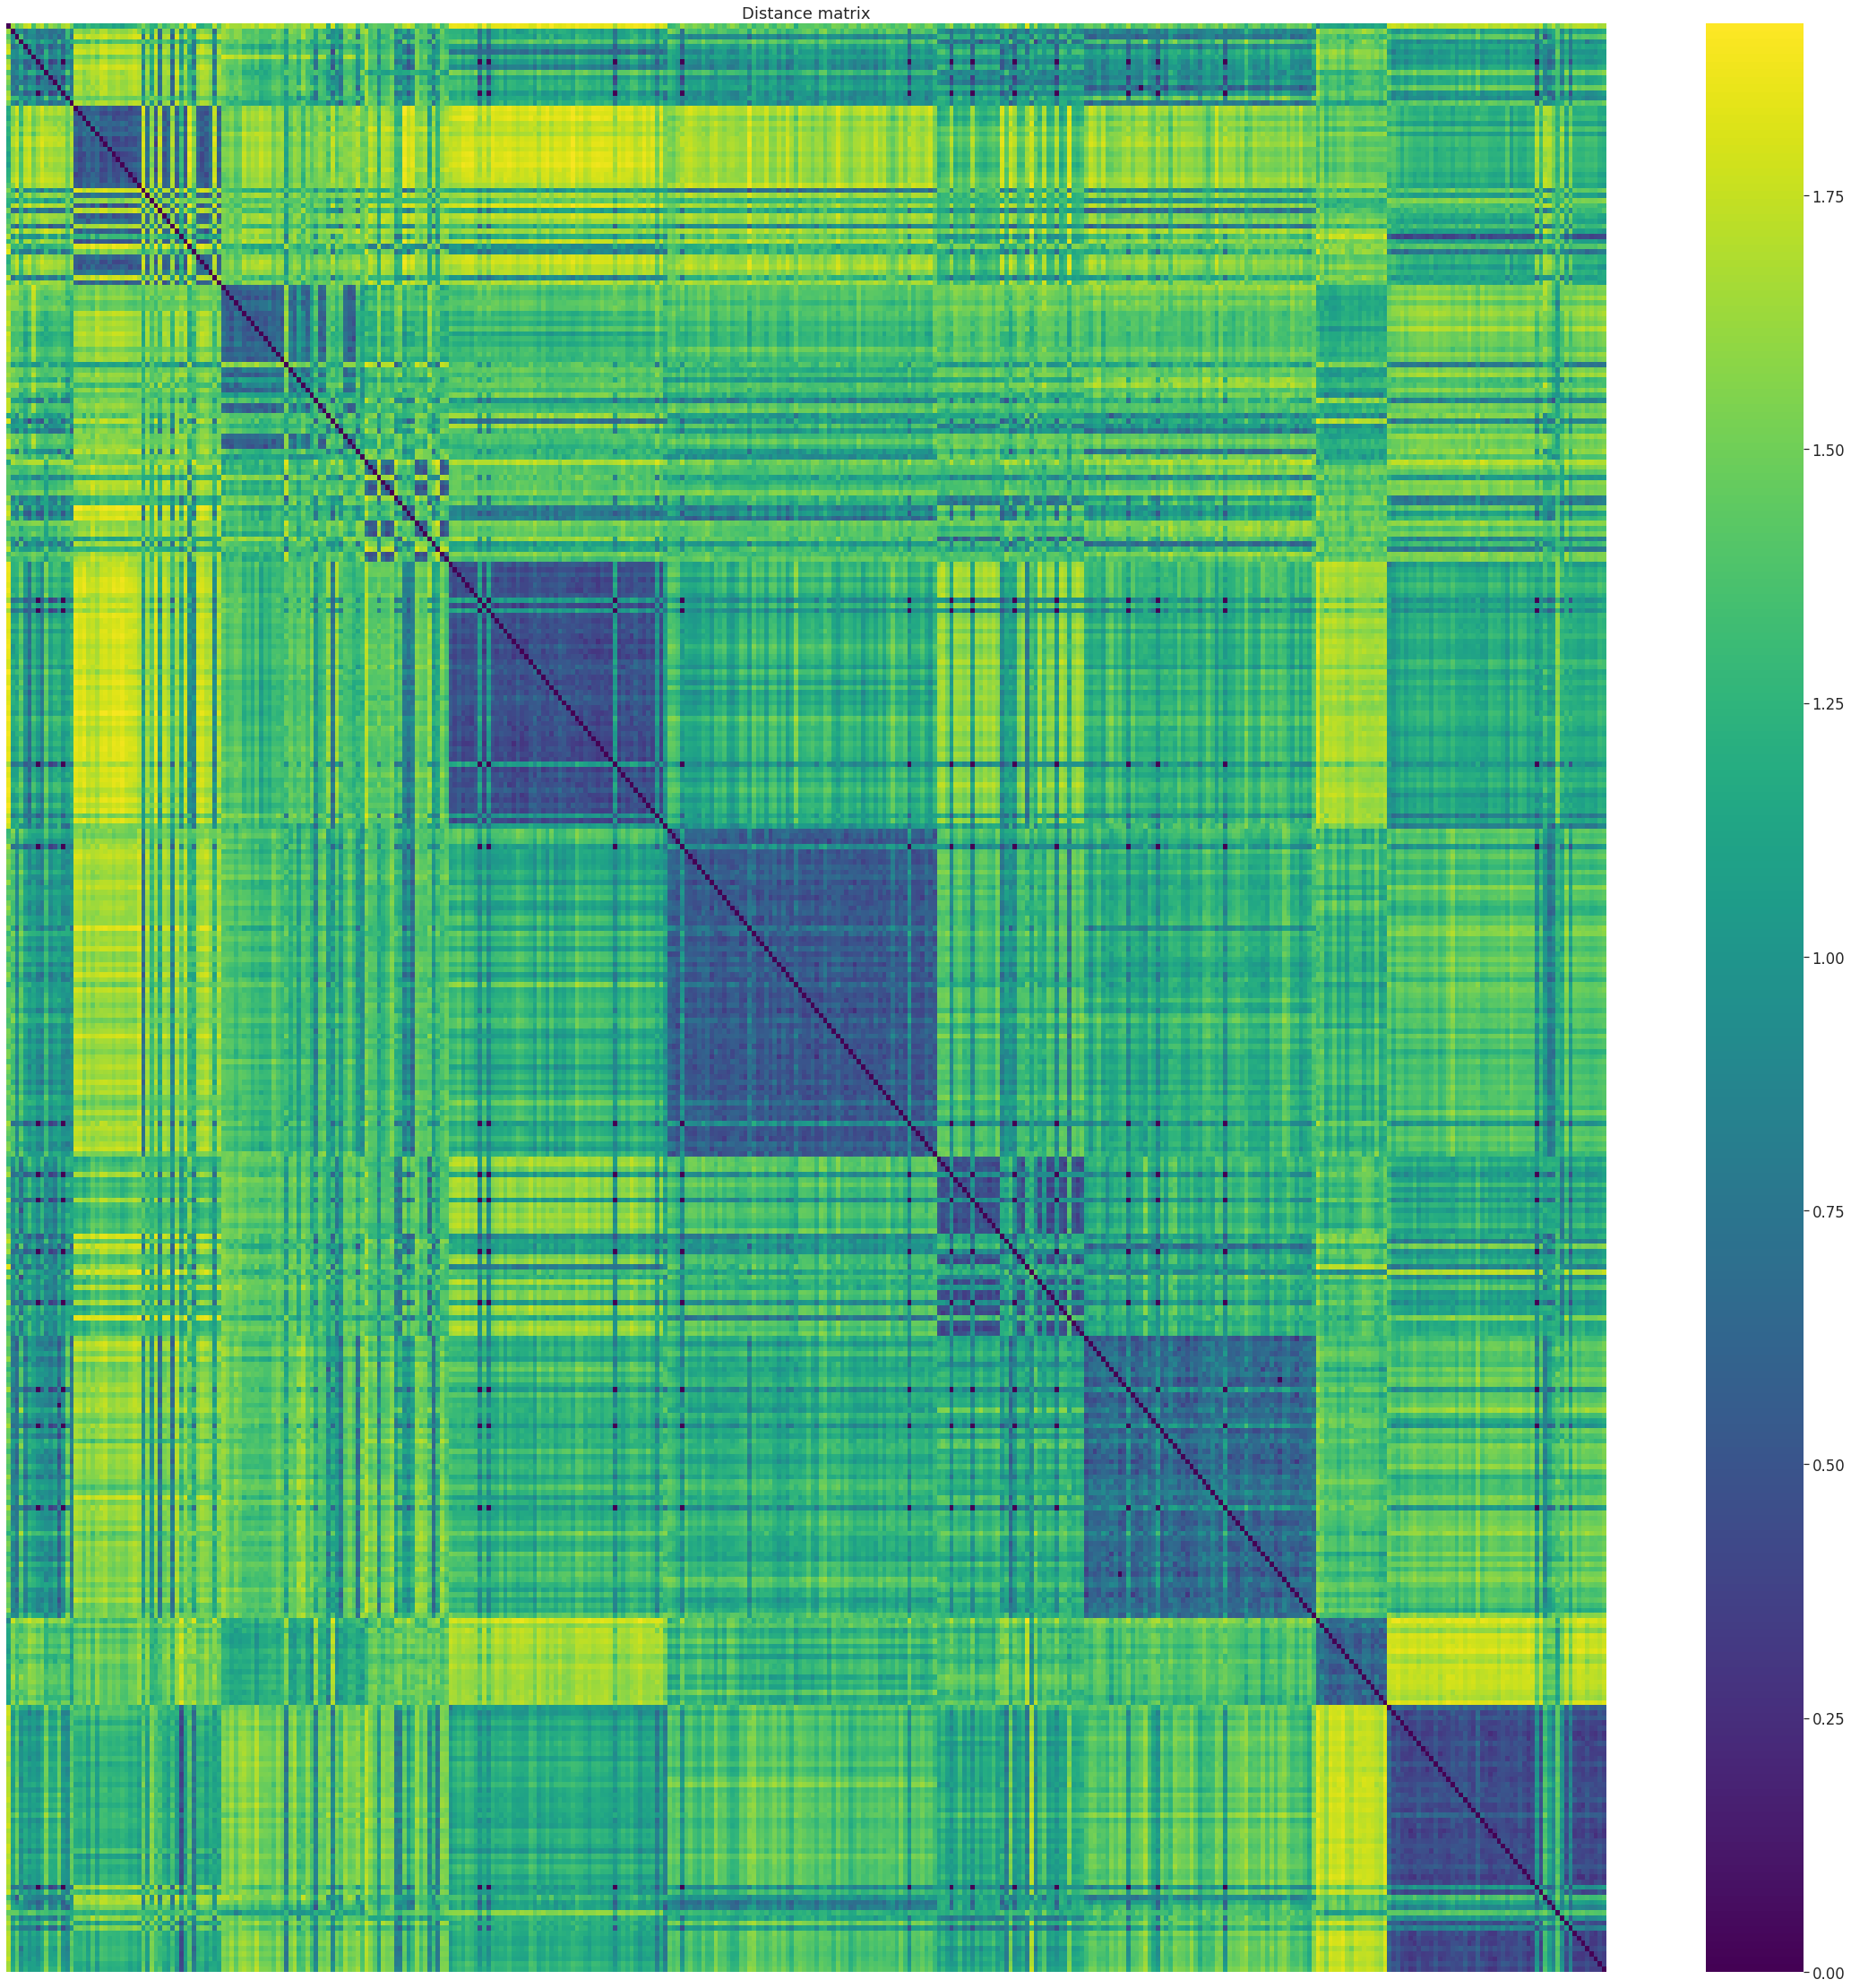

In [59]:
plot_distance_matrix(true_distances, [])

In [196]:

temp = list(filter(groupby='organ', emb='avg', dist_from='tsne')['tsne'])
x = np.array([list(x) for x in temp])

array([[-6.1189165 , -8.626813  ],
       [-5.0275455 , -4.968426  ],
       [12.481435  ,  2.3010416 ],
       [ 4.273013  , 12.813963  ],
       [-1.0143046 ,  0.09448827],
       [ 2.5660963 ,  4.559185  ],
       [ 0.31525964, -7.3564844 ]], dtype=float32)

In [199]:
list(filter(groupby='organ', emb='avg', dist_from='tsne').index)

['Brain', 'Heart', 'Kidney', 'Liver', 'Lungs', 'Pancreas', 'Prostate']

In [200]:
f = filter(groupby='organ', emb='avg', dist_from='tsne')

In [209]:
for i,d in enumerate(f['tsne']):
    print(i,d)

0 [-6.1189165 -8.626813 ]
1 [-5.0275455 -4.968426 ]
2 [12.481435   2.3010416]
3 [ 4.273013 12.813963]
4 [-1.0143046   0.09448827]
5 [2.5660963 4.559185 ]
6 [ 0.31525964 -7.3564844 ]


In [77]:
# Do T-sne visualization of the embeddings in data_emb_list
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE, LocallyLinearEmbedding, LocallyLinearEmbedding, SpectralEmbedding, MDS, Isomap
from sklearn.decomposition import PCA

# Visualize embeddings
def visualize_embeddings_only(data_emb_list, title, category, emb = 'tsne'):
    
    colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'indigo', 'lime', 'olive', 'teal', 'navy', 'maroon', 'black', 'gold', 'silver', 'gray', 'crimson', 'darkblue', 'darkgreen', 'darkred', 'darkorange', 'darkviolet', 'darkcyan', 'darkmagenta', 'darkgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightblue', 'lightgreen', 'lightyellow', 'lightgray', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray']
        
    plt.figure(figsize=(20, 20))
    
    for i in range(len(data_emb_list)):
        x, y = data_emb_list.iloc[i][emb]
        plt.scatter(x, y, c=colors[i%len(colors)], s=50)
        plt.annotate(data_emb_list.iloc[i][category] if 'M_' not in data_emb_list.iloc[i]['name'] else '', (x, y), fontsize=18 if 'M_' not in data_emb_list.iloc[i]['name'] else 9, color=colors[i%len(colors)] if 'M_' not in data_emb_list.iloc[i][category] else 'black')
    plt.title(title)
    plt.show()

In [78]:
final_emb_list.iloc[0]['tsne']

array([-7.7173963,  1.380277 ], dtype=float32)

In [79]:
x = final_emb_list.to_dict()
for i, d in enumerate(x):
    print(i,d)

0 name
1 emb
2 dataset
3 color
4 type
5 organ
6 pathologies
7 location
8 size
9 modality
10 classes
11 best_epoch
12 f1
13 loss
14 model_path
15 model
16 with_aug
17 balanced
18 pretrained
19 batch_128
20 topn
21 f_emb
22 pca
23 tsne
24 isomap
25 lle


In [182]:
dist_from = ['pca','tsne','emb']
groupby = ['organ', 'dataset', 'pathologies','modality']
type = ['avg','x']
for _dist_from in dist_from:
    for _groupby in groupby:
        for _type in type:
            d = filter(groupby=_groupby, emb=_type, dist_from=_dist_from)
            visualize_embeddings_only(d, '%s %s %s'%(_groupby, _type, _dist_from))
            #distances, labels = get_distances(d, dist_from=_dist_from)

NameError: name 'results' is not defined

<Figure size 1440x1440 with 0 Axes>

In [43]:
pd.DataFrame(data_emb_list)

,name,emb,dataset,color,type,organ,pathologies,location,size,modality,...,f1,loss,model_path,model,with_aug,balanced,pretrained,batch_128,topn,f_emb
0,MosMed,"[-0.09513576, -0.07498257, 0.018053403, -0.004...",MosMed,1,data,Lungs,COVID-19,[Russia],3200.0,CT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M_0.77,"[-0.041001327, -0.011824959, -0.036100432, -0....",MosMed,1,model,NaN,NaN,NaN,NaN,NaN,...,0.768421,0.074524,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,mobilenet_v2,True,True,False,True,top-7,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,M_0.81,"[-0.032405473, -0.030662633, -0.0034572429, -0...",MosMed,1,model,NaN,NaN,NaN,NaN,NaN,...,0.806202,0.170831,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,efficientnet_b4,True,False,False,False,top-7,"[tensor(0.0108), tensor(0.0750), tensor(0.0112..."
3,M_0.70,"[-0.0613609, 0.00025926784, -0.028130552, -0.0...",MosMed,1,model,NaN,NaN,NaN,NaN,NaN,...,0.703252,0.430663,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,densenet121,True,True,False,True,top-7,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
4,M_0.76,"[-0.05240414, -0.054933082, 0.027191985, -0.08...",MosMed,1,model,NaN,NaN,NaN,NaN,NaN,...,0.764286,0.126464,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,mobilenet_v2,False,False,False,False,top-7,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,M_0.74,"[0.064141855, 0.10252589, -0.15254916, 0.06292...",RSNAXRay,11,model,NaN,NaN,NaN,NaN,NaN,...,0.744828,0.542110,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,densenet121,True,False,False,True,raw,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
483,M_0.64,"[0.021423113, 0.18113606, -0.10310141, 0.03988...",RSNAXRay,11,model,NaN,NaN,NaN,NaN,NaN,...,0.637255,2.097646,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,efficientnet_b4,True,False,False,True,raw,"[tensor(217.7893), tensor(-0.0106), tensor(19...."
484,M_0.77,"[-0.0011156572, 0.09980263, -0.047153402, 0.01...",RSNAXRay,11,model,NaN,NaN,NaN,NaN,NaN,...,0.772152,1.330657,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,efficientnet_b4,True,True,True,True,raw,"[tensor(-0.1437), tensor(-0.1512), tensor(-0.1..."
485,M_0.72,"[0.00408792, 0.13673158, -0.044844892, 0.05257...",RSNAXRay,11,model,NaN,NaN,NaN,NaN,NaN,...,0.719212,1.303484,/nfs/projects/mbzuai/BioMedIA/MICCIA_22/logs/c...,efficientnet_b4,True,True,False,True,raw,"[tensor(0.1170), tensor(0.0038), tensor(0.0715..."


explained variance ratio (first two components): [0.23942041 0.19779355]


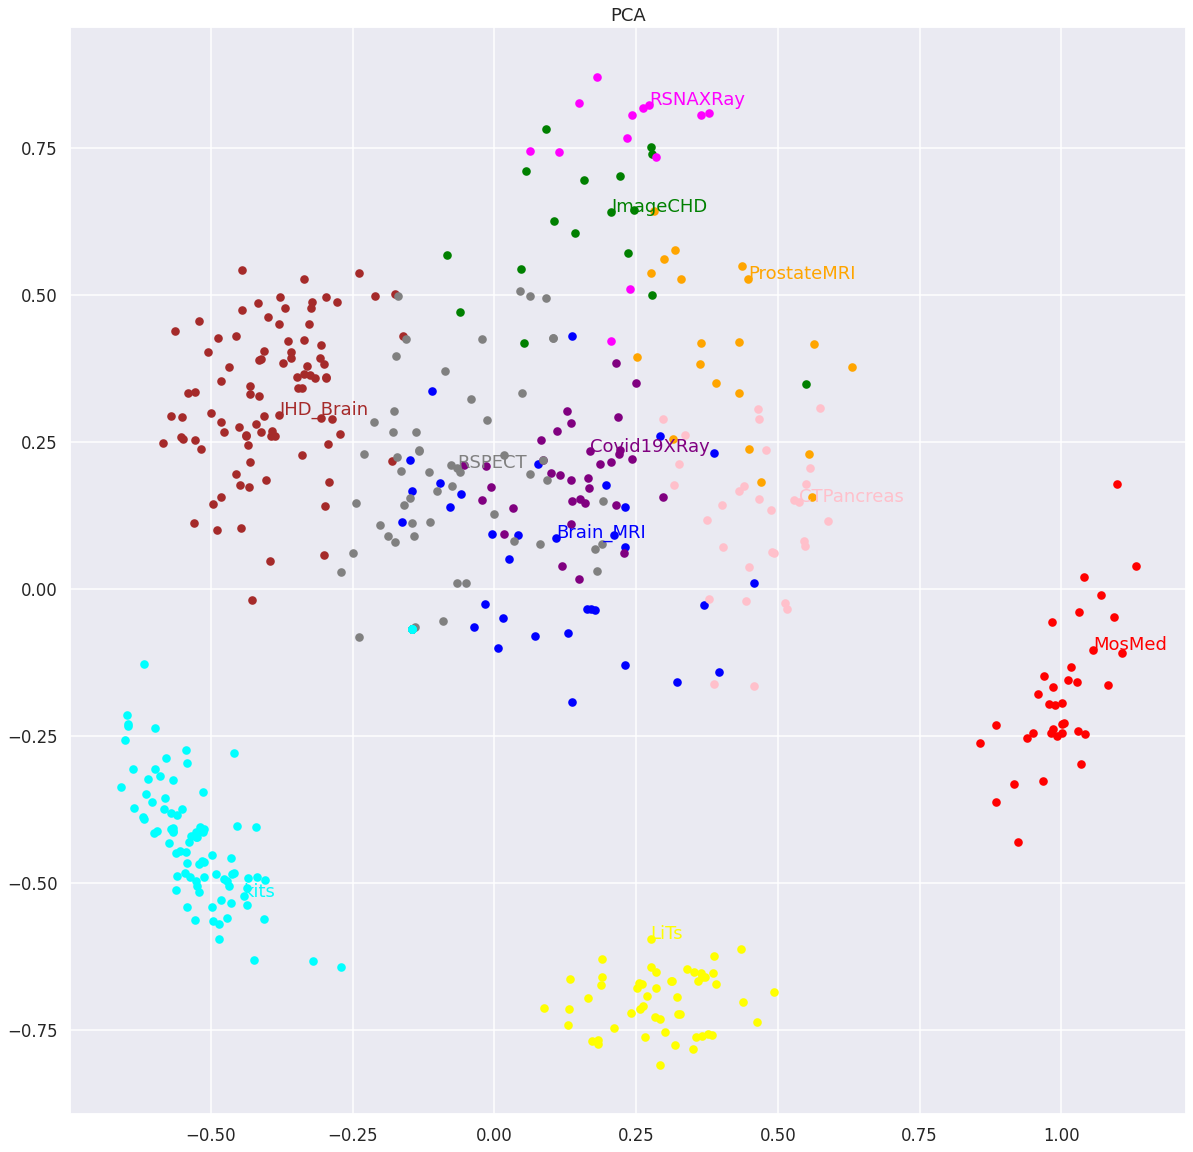

In [80]:
# PCA Visualization
visualize_embeddings(data_emb_list, 'PCA', 'pca', return_emb=False)

In [ ]:
DATASET_ATTR = {
    "MosMed": {
        "organ": "Lungs",
        "pathologies": "COVID-19",
        "location": ["Russia"],
        "size": 3200,
        "modality": "CT",
        "classes": ["COVID-19 Positive", "COVID-19 Negative"],
    },
    "kits": {
        "organ": "Kidney",
        "pathologies": "Cancer",
        "location": ["USA"],
        "size": 13888,
        "modality": "CT",
        "classes": ["Benign", "Malignant"],
    },
    "LiTs": {
        "organ": "Liver",
        "pathologies": "Cancer",
        "location": ["Germany", "Netherlands", "Canada", "Israel"],
        "size": 8384,
        "modality": "CT",
        "classes": ["No_Tumor", "Tumor"],
    },
    "RSPECT": {
        "organ": "Lungs",
        "pathologies": "Pulmonary Embolism",
        "location": ["Australia", "Turkey", "USA", "Canada", "Brazil"],
        "size": 15000,
        "modality": "CT",
        "classes": ["No_PE", "PE"],
    },
    "IHD_Brain": {
        "organ": "Brain",
        "pathologies": "Intracranial Hemorrhage",
        "location": ["USA", "Brazil"],
        "size": 15000,
        "modality": "CT",
        "classes": ["No_IHD", "IHD"],
    },
    "ImageCHD": {
        "organ": "Heart",
        "pathologies": "Congenital Heart Disease",
        "location": ["China"],
        "size": 6336,
        "modality": "CT",
        "classes": ["No_CHD", "CHD"],
    },
    "CTPancreas": {
        "organ": "Pancreas",
        "pathologies": "Pancreatic Cancer",
        "location": ["USA"],
        "size": 5120,
        "modality": "CT",
        "classes": ["No_Tumor", "Tumor"],
    },
    "Brain_MRI": {
        "organ": "Brain",
        "pathologies": "Brain Tumour",
        "location": ["Global"],
        "size": 3160,
        "modality": "MRI",
        "classes": [
            "glioma_tumor",
            "meningioma_tumor",
            "no_tumor",
            "pituitary_tumor",
        ],
    },
    "ProstateMRI": {
        "organ": "Prostate",
        "pathologies": "Prostate Cancer",
        "location": ["USA"],
        "size": 2561,
        "modality": "MRI",
        "classes": ["No_Tumor", "Tumor"],
    },
    "RSNAXRay": {
        "organ": "Lungs",
        "pathologies": "Tuberculosis",
        "location": ["USA", "China"],
        "size": 801,
        "modality": "Xray",
        "classes": ["No_TB", "TB"],
    },
    "Covid19XRay": {
        "organ": "Lungs",
        "pathologies": "COVID-19",
        "location": ["Spain", "USA"], # Check again
        "size": 6057,
        "modality": "Xray",
        "classes": [
            "Negative for Pneumonia",
            "Typical Appearance",
            "Indeterminate Appearance",
            "Atypical Appearance",
        ],
    },
}


# Contour Visualization
visualize_embeddings(data_emb_list, 'LLE', 'lle', return_emb=False)


In [1]:
# TSNE Visualization
visualize_embeddings(data_emb_list, 'TSNE', 'tsne', return_emb=False)

NameError: name 'visualize_embeddings' is not defined

In [111]:
DATASET_ATTR = {
    "MosMed": {
        "organ": "Lungs",
        "pathologies": "COVID-19",
        "location": ["Russia"],
        "size": 3200,
        "modality": "CT",
        "classes": ["COVID-19 Positive", "COVID-19 Negative"],
    },
    "kits": {
        "organ": "Kidney",
        "pathologies": "Cancer",
        "location": ["USA"],
        "size": 13888,
        "modality": "CT",
        "classes": ["Benign", "Malignant"],
    },
    "LiTs": {
        "organ": "Liver",
        "pathologies": "Cancer",
        "location": ["Germany", "Netherlands", "Canada", "Israel"],
        "size": 8384,
        "modality": "CT",
        "classes": ["No_Tumor", "Tumor"],
    },
    "RSPECT": {
        "organ": "Lungs",
        "pathologies": "Pulmonary Embolism",
        "location": ["Australia", "Turkey", "USA", "Canada", "Brazil"],
        "size": 15000,
        "modality": "CT",
        "classes": ["No_PE", "PE"],
    },
    "IHD_Brain": {
        "organ": "Brain",
        "pathologies": "Intracranial Hemorrhage",
        "location": ["USA", "Brazil"],
        "size": 15000,
        "modality": "CT",
        "classes": ["No_IHD", "IHD"],
    },
    "ImageCHD": {
        "organ": "Heart",
        "pathologies": "Congenital Heart Disease",
        "location": ["China"],
        "size": 6336,
        "modality": "CT",
        "classes": ["No_CHD", "CHD"],
    },
    "CTPancreas": {
        "organ": "Pancreas",
        "pathologies": "Pancreatic Cancer",
        "location": ["USA"],
        "size": 5120,
        "modality": "CT",
        "classes": ["No_Tumor", "Tumor"],
    },
    "Brain_MRI": {
        "organ": "Brain",
        "pathologies": "Brain Tumour",
        "location": ["Global"],
        "size": 3160,
        "modality": "MRI",
        "classes": [
            "glioma_tumor",
            "meningioma_tumor",
            "no_tumor",
            "pituitary_tumor",
        ],
    },
    "ProstateMRI": {
        "organ": "Prostate",
        "pathologies": "Prostate Cancer",
        "location": ["USA"],
        "size": 2561,
        "modality": "MRI",
        "classes": ["No_Tumor", "Tumor"],
    },
    "RSNAXRay": {
        "organ": "Lungs",
        "pathologies": "Tuberculosis",
        "location": ["USA", "China"],
        "size": 801,
        "modality": "Xray",
        "classes": ["No_TB", "TB"],
    },
    "Covid19XRay": {
        "organ": "Lungs",
        "pathologies": "COVID-19",
        "location": ["Spain", "USA"], # Check again
        "size": 6057,
        "modality": "Xray",
        "classes": [
            "Negative for Pneumonia",
            "Typical Appearance",
            "Indeterminate Appearance",
            "Atypical Appearance",
        ],
    },
}


In [191]:

f_list = pd.DataFrame(final_emb_list)
temp = f_list.copy()
for index in range(len(f_list)):
    f_list.loc[index, 'organ'] = DATASET_ATTR[f_list.loc[index, 'dataset']]['organ']
    f_list.loc[index, 'pathologies'] = DATASET_ATTR[f_list.loc[index, 'dataset']]['pathologies']
    #f_list.loc[index, 'location'] = DATASET_ATTR[f_list.loc[index, 'dataset']]['location']
    f_list.loc[index, 'size'] = DATASET_ATTR[f_list.loc[index, 'dataset']]['size']
    f_list.loc[index, 'modality'] = DATASET_ATTR[f_list.loc[index, 'dataset']]['modality']
    #f_list.loc[index, 'classes'] = DATASET_ATTR[f_list.loc[index, 'dataset']]['classes']

def filter_process(f_list, attribute, dim_type = 'tsne'):
    X = f_list[dim_type].to_numpy().copy()
    y = f_list[attribute].to_numpy().copy()
    # Map values of y to numbers
    y_map = {}
    for i in range(len(y)):
        if y[i] not in y_map:
            y_map[y[i]] = len(y_map)
   # replace all values in y with mapped values
    for i in range(len(y)):
        y[i] = y_map[y[i]]
    
    X = np.array([list(x) for x in X]).astype(np.float32)
    return X, y.astype(np.int32), y_map

In [192]:
X, y, y_map = filter_process(f_list, attribute='organ', dim_type='tsne')

In [203]:
np.c_[xx.ravel(), yy.ravel()].shape

(250000, 2)

In [201]:
xx, yy = np.meshgrid(np.linspace(-4, 5, 500), np.linspace(-4, 5, 500))

In [238]:
y_map

{'Lungs': 0,
 'Brain': 1,
 'Heart': 2,
 'Liver': 3,
 'Prostate': 4,
 'Pancreas': 5,
 'Kidney': 6}

(1537, 1470)
(1537, 1470)
(2259390,)


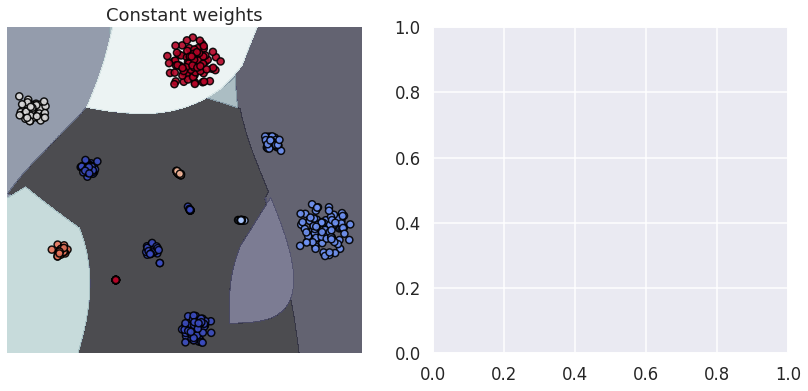

In [281]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

def make_meshgrid(x, y, h=0.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_decision_function(classifier, axis, title):
    # plot the decision function
    xx, yy = make_meshgrid(X[:,0],X[:,1])
    print(xx.shape)
    print(yy.shape)
    # Predict probabilities for each sample


    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    _Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    print(Z.shape)
    colors = reduce_to_single_channel(Z, _Z)
    Z = Z.reshape(xx.shape)
    colors = colors.reshape(xx.shape)
    # plot the line, the points, and the nearest vectors to the plane
    axis.contourf(xx, yy, colors, alpha=0.75, cmap=plt.cm.coolwarm)
    axis.scatter(
        X[:, 0],
        X[:, 1],
        c=y,
        s=50,
        alpha=0.9,
        cmap=plt.cm.coolwarm, #plt.cm.bone,
        edgecolors="black",
    )

    axis.axis("off")
    axis.set_title(title)
    

X, y, y_map = filter_process(f_list, attribute='organ', dim_type='tsne')

clf_no_weights = svm.SVC(kernel = 'poly', gamma=1e-2, probability=True)
clf_no_weights.fit(X, y)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_decision_function(
    clf_no_weights, axes[0], "Constant weights"
)
plt.show()

In [1]:
X, y, y_map = filter_process(f_list, attribute='organ', dim_type='tsne')
clf_no_weights = svm.SVC(kernel = 'poly', gamma=100, probability=True)
clf_no_weights.fit(X, y)

NameError: name 'filter_process' is not defined

In [ ]:

a = clf_no_weights.predict_proba(np.c_[xx.ravel(), yy.ravel()])
b = clf_no_weights.predict(np.c_[xx.ravel(), yy.ravel()])

In [ ]:
b.max()

4

In [305]:
def reduce_to_single_channel(raw, probs):
    mod = []
    for i in range(raw.shape[0]):
        _x = raw[i] + probs[i,raw[i]]
        mod.append(_x)
    return np.array(mod)

In [306]:
pd.DataFrame(reduce_to_single_channel(b,a)).max()

0    0.664493
dtype: float64

In [206]:
1537 * 1470

2259390

In [198]:
import math
math.sqrt(1750000)

1322.8756555322952

# Isomap Visualization
visualize_embeddings(data_emb_list, 'Isomap', 'isomap', return_emb=False)

In [28]:
# Use plotly to plot force directed graph representation of the distance matrix
import plotly.graph_objs as go

def plot_graph(distances, labels, title):
    x = [d[0] for d in distances]
    y = [d[1] for d in distances]
    z = [d[2] for d in distances]
    trace1 = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=12,
            color=labels,
            colorscale='Viridis',
            opacity=0.8
        )
    )
    layout = go.Layout(
        title=title,
        width=800,
        height=800,
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        ),
        scene=dict(
            xaxis=dict(
                title='PC1',
                titlefont=dict(
                    size=14,
                    color='#7f7f7f'
                ),
                tickfont=dict(
                    size=12,
                    color='#7f7f7f'
                )
            ),
            yaxis=dict(
                title='PC2',
                titlefont=dict(
                    size=14,
                    color='#7f7f7f'
                ),
                tickfont=dict(
                    size=12,
                    color='#7f7f7f'
                )
            ),
            zaxis=dict(
                title='PC3',
                titlefont=dict(
                    size=14,
                    color='#7f7f7f'
                ),
                tickfont=dict(
                    size=12,
                    color='#7f7f7f'
                )
            )
        )
    )
    fig = go.Figure(data=[trace1], layout=layout)
    fig.show()



In [29]:
plot_graph(true_emb, true['color'], 'True Embeddings')